### Create readme.txt file

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import savemat

sys.path.append(os.path.abspath('../../helper'))
import utils
import loader
import plotfig

sys.path.append('../../train/Pix2Pix/')
sys.path.append('../../train/Pix2Pix/helperPix2Pix')
from generator_model import Generator, Generator_FineTune
from discriminator_model import Discriminator, Discriminator_FineTune
from trainPix2Pix import train_fn, validate_fn

In [2]:
source_models_dir  = "../../model/static/GAN/BS16/3500_3516/ver17_"
target_data_dir    = "../../../CDL Customization/Data/ver39_"

epoch_load = 40 # load model trained at {epoch_load}

# Min-max Scaler to [-1 1] range
norm_approach = 'minmax'
lower_range = -1
train_rate = 0.3 # train_rate/(1-train_rate) for training/validating at transferring

# create readme.txt file
content = f"""Generated by file 'transfer/Pix2Pix/transfer_v1.ipynb'.
Source models were loaded in {source_models_dir}, load models at epoch {epoch_load}
Target training data are loaded in {target_data_dir}
1000 samples in target dataset (map-based dataset), {str(train_rate)} for training, {str(1-train_rate)} for validating and evaluating
"""

idx_save_path = loader.find_incremental_filename('../transferd_model/static/GAN', 'ver', '_', '')
transferd_save_path = f"../transferd_model/static/GAN/ver{idx_save_path}_"

os.makedirs(os.path.dirname(f'{transferd_save_path}/readme.txt'), exist_ok=True)

# Write content to readme.txt
with open(transferd_save_path + '/readme.txt', "w") as file:
    file.write(content)

In [3]:
# Straightly applying trained model to target data

In [4]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 32 #64  # Batch size
NUM_EPOCHS = 20 # 20
learning_rate = 1e-5 # 1e-5
SNR = np.arange(-25, 31, 5) # 0:5:30 dB

nmse_LS_LI_val   = []
nmse_LS_NN_val   = []
nmse_LI_NN_val   = []

for snr in SNR:
    print(f" SNR: {snr}/{SNR[-1]}")
    # load target dataset
    [trainLabels, valLabels], [H_equal_train, H_linear_train, H_practical_train], [H_equal_val, H_linear_val, H_practical_val] = loader.load_map_data(target_data_dir, device, snr, train_rate=train_rate)
            
    # training at target set
    for model_name in ['LS_GAN', 'LS_LI_GAN']:
        print(f'{model_name} model')
        
        if model_name == 'LS_GAN':
            train_loader, trainLabel_min, trainLabel_max = loader.genLoader(H_equal_train, trainLabels, BATCH_SIZE, device, 'train', True, norm_approach, lower_range=lower_range)
            val_loader,     valLabel_min,   valLabel_max = loader.genLoader(H_equal_val,     valLabels, BATCH_SIZE, device, 'valid', False, norm_approach, lower_range=lower_range)
            # no shuffle in validation so valLabel_min and valLable_max remain the min and max arrays
                                                                                        # of valLabels
            # train_loader, val_loader are already normalized by their own min, max
            # scale to range [0 1] or [-1 1]
            
        elif model_name == 'LS_LI_GAN':
            train_loader, trainLabel_min, trainLabel_max = loader.genLoader(H_linear_train, trainLabels, BATCH_SIZE, device, 'train', True, norm_approach, lower_range=lower_range)
            val_loader,     valLabel_min,   valLabel_max = loader.genLoader(H_linear_val,     valLabels, BATCH_SIZE, device, 'valid', False, norm_approach, lower_range=lower_range)
            # no shuffle in validation so valLabel_min and valLable_max remain the min and max arrays
                                                                                        # of valLabels
            # train_loader, val_loader are already normalized by their own min, max
            # scale to range [0 1] or [-1 1]
            
        # source model
        gan_G_source = Generator()
        gan_D_source = Discriminator()
        
        checkpointG = torch.load(os.path.join(source_models_dir, f'{snr}dB', f'{epoch_load}epoc_G_1_{model_name}_model.pth'))
        gan_G_source.load_state_dict(checkpointG['model_state_dict'])
        checkpointD = torch.load(os.path.join(source_models_dir, f'{snr}dB', f'{epoch_load}epoc_D_1_{model_name}_model.pth'))
        gan_D_source.load_state_dict(checkpointD['model_state_dict'])
        
        G_fineTune = Generator_FineTune(gan_G_source).to(device)        
        D_fineTune = Discriminator_FineTune(gan_D_source).to(device)         
        opt_disc = torch.optim.Adam(D_fineTune.parameters(), lr=learning_rate, betas=(0.5, 0.999))
        opt_gen = torch.optim.Adam(G_fineTune.parameters(), lr=learning_rate, betas=(0.5, 0.999))
        BCE = nn.BCEWithLogitsLoss()
        L1_LOSS = nn.L1Loss()
        
        train_loss =[]
        train_Dloss = []
        nmse_gen = []
        mse_gen = []
        val_loss = []
        H_NN_val = torch.empty_like(valLabels) # [nVal, 2, 612, 14]
        min_H_true = []
        max_H_true = []
        
        for epoch in range(NUM_EPOCHS):
            G_fineTune.train()
            D_fineTune.train()
            
            ##############
            flag_last_epoch = (epoch == NUM_EPOCHS-1) # last epoch
            train_loss_iEpoc, train_D_loss_iEpoc, mse_gen_iEpoc, nmse_gen_iEpoc = train_fn(D_fineTune, G_fineTune,
                                                                            train_loader, opt_disc, opt_gen, 
                                                                            L1_LOSS, BCE, return_mse=True, return_nmse=True)
            
            # Validation step
            if flag_last_epoch==True:
                val_loss_iEpoc, H_NN_val = validate_fn(G_fineTune, val_loader, L1_LOSS, BCE, flag_last_epoch)
            else:
                val_loss_iEpoc = validate_fn(G_fineTune, val_loader, L1_LOSS, BCE, flag_last_epoch)

            train_loss.append(train_loss_iEpoc)  
            train_Dloss.append(train_D_loss_iEpoc)  
            val_loss.append(val_loss_iEpoc)
            mse_gen.append(mse_gen_iEpoc)
            nmse_gen.append(nmse_gen_iEpoc)
            ############
            
            print(f"SNR: {snr}/{SNR[-1]}, {model_name}, Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {train_loss_iEpoc} ") 
                    
            print(f"SNR: {snr}/{SNR[-1]}, {model_name}, Val Loss: {val_loss_iEpoc}")
        # end loop epochs
        
        train_save_path = f'{transferd_save_path}/{snr}dB/train'
            # transferd_save_path = f"../transferd_model/static/GAN/ver{idx_save_path}_"
        os.makedirs(train_save_path, exist_ok=True)
        
        savemat(f'{train_save_path}/{model_name}_loss.mat', {'valG_loss': val_loss, 
                                                            'trainG_loss': train_loss,
                                                            'trainD_loss': train_Dloss,
                                                            'mse_gen': mse_gen,
                                                            'nmse_gen': nmse_gen})
        
        plotfig.figLoss(train_loss, val_loss, 1, train_save_path, f'_{model_name}_valLoss.png', ylabel='BCE Loss')
        plotfig.figLoss(train_loss, None, 1, train_save_path, f'_{model_name}_trainLoss.png', trainD_loss = train_Dloss, ylabel='BCE Loss', train_loss_legend='Generator Loss', title='Generator and Discriminator Loss')
        
        torch.save({
            'model_state_dict': G_fineTune.state_dict(),
            'optimizer_state_dict': opt_gen.state_dict()
            }, f'{transferd_save_path}/{snr}dB/{model_name}_G_model.pth')
                
        torch.save({
            'model_state_dict': D_fineTune.state_dict(),
            'optimizer_state_dict': opt_disc.state_dict()
            }, f'{transferd_save_path}/{snr}dB/{model_name}_D_model.pth')
    
        
        # Denormalize True Channel
        H_val_true = valLabels.cpu()
        # convert to complex matrices
        H_val_true_complex = torch.complex(H_val_true[:,0,:,:], H_val_true[:,1,:,:])
        # variables['H_val_true'] = H_val_true # (nVal, 2, 612, 14)
        plotfig.figTrueChan(H_val_true[-1,0,:,:], 'True Channel', 1, train_save_path, '_trueChannel.png')
                            # train_save_path = f'transferd_model/static/GAN/ver{idx_save_path}_/{snr}dB/train'

        
        # GAN Estimated Channel                                                               
        H_val_NN_denormd = utils.deNorm(H_NN_val, valLabel_min, valLabel_max, norm_approach, lower_range=lower_range)
                            #     H_NN_val == [nVal, 2, 612, 14] 
                            # valLabel_min == [nVal,1]
        H_val_NN_denormd = H_val_NN_denormd.cpu()
        
        # NMSE of LS (+ LI) + GAN
        H_val_NN_complex = torch.complex(H_val_NN_denormd[:,0,:,:], H_val_NN_denormd[:,1,:,:])# Calculate the NMSE
        nmse_NN = utils.calNMSE(H_val_NN_complex, H_val_true_complex)
            
        if model_name == 'LS_GAN':
            nmse_LS_NN_val.append(nmse_NN.cpu().mean())
            print(f"LS+GAN NMSE: {nmse_NN.cpu().mean()}")
            
            plotfig.figPredChan(H_val_NN_denormd[-1,0,:,:], 'LS+GAN Estimated Channel',
                                    nmse_NN[-1], 1, train_save_path, '_LS_GAN_estimatedChan.png')
                                # train_save_path = f'transferd_model/static/GAN/ver{idx_save_path}_/{snr}dB/train'
        
            # NMSE of Linear Interpolation   # just need to calculate this 1 time  --> calculate at case model_name == 'LS_GAN'
            H_val_linInterp = H_linear_val.cpu()
            # convert to complex matrices
            H_val_linInterp_complex = torch.complex(H_val_linInterp[:,0,:,:], H_val_linInterp[:,1,:,:]) # [?, 612, 14]
            nmse_LI = utils.calNMSE(H_val_linInterp_complex, H_val_true_complex)
            
            nmse_LS_LI_val.append(nmse_LI.cpu().mean())
            print(f"LS+LI NMSE: {nmse_LI.cpu().mean()}")
            
            plotfig.figPredChan(H_val_linInterp[-1,0,:,:], 'LS + Interpolate Estimated Channel',
                                    nmse_LI[-1], 1, train_save_path, '_LS_LI_estimatedChan.png')
                            # train_save_path = f'transferd_model/static/GAN/ver{idx_save_path}_/{snr}dB/train'
                            
        elif model_name == 'LS_LI_GAN':
            nmse_LI_NN_val.append(nmse_NN.cpu().mean())
            print(f"LS+GAN NMSE: {nmse_NN.cpu().mean()}")
            
            plotfig.figPredChan(H_val_NN_denormd[-1,0,:,:], 'LS+LI+GAN Estimated Channel',
                                    nmse_NN[-1], 1, train_save_path, '_LS_LI_GAN_estimatedChan.png')
                                # train_save_path = f'transferd_model/static/GAN/ver{idx_save_path}_/{snr}dB/train'
    
    # end model_phase ['LS_GAN', 'LS_LI_GAN']
# end loop SNR

 SNR: -25/30


/home/thien/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


LS_GAN model


100%|██████████| 18/18 [00:03<00:00,  4.90it/s, D_fake=0.0205, D_real=0.971]


Training Generator Loss: 64.3972
Validation Loss: 58.8561
SNR: -25/30, LS_GAN, Epoch 1/20, Loss: 64.39715237087674 
SNR: -25/30, LS_GAN, Val Loss: 58.85606848675272


100%|██████████| 18/18 [00:01<00:00, 14.54it/s, D_fake=0.085, D_real=0.974] 


Training Generator Loss: 61.6152
Validation Loss: 58.6105
SNR: -25/30, LS_GAN, Epoch 2/20, Loss: 61.61521954006619 
SNR: -25/30, LS_GAN, Val Loss: 58.61048773060674


100%|██████████| 18/18 [00:01<00:00, 14.57it/s, D_fake=0.201, D_real=0.977]


Training Generator Loss: 59.9978
Validation Loss: 58.2901
SNR: -25/30, LS_GAN, Epoch 3/20, Loss: 59.997776667277016 
SNR: -25/30, LS_GAN, Val Loss: 58.29007057521654


100%|██████████| 18/18 [00:01<00:00, 14.56it/s, D_fake=0.426, D_real=0.925]


Training Generator Loss: 58.7076
Validation Loss: 57.8624
SNR: -25/30, LS_GAN, Epoch 4/20, Loss: 58.70755958557129 
SNR: -25/30, LS_GAN, Val Loss: 57.862374347189196


100%|██████████| 18/18 [00:01<00:00, 14.49it/s, D_fake=0.526, D_real=0.935]


Training Generator Loss: 57.4757
Validation Loss: 57.5307
SNR: -25/30, LS_GAN, Epoch 5/20, Loss: 57.475719663831924 
SNR: -25/30, LS_GAN, Val Loss: 57.5306570633598


100%|██████████| 18/18 [00:01<00:00, 14.47it/s, D_fake=0.566, D_real=0.83] 


Training Generator Loss: 56.8662
Validation Loss: 57.2126
SNR: -25/30, LS_GAN, Epoch 6/20, Loss: 56.866233825683594 
SNR: -25/30, LS_GAN, Val Loss: 57.212580473526664


100%|██████████| 18/18 [00:01<00:00, 14.37it/s, D_fake=0.787, D_real=0.882]


Training Generator Loss: 56.2507
Validation Loss: 56.8420
SNR: -25/30, LS_GAN, Epoch 7/20, Loss: 56.250746197170685 
SNR: -25/30, LS_GAN, Val Loss: 56.842010995616086


100%|██████████| 18/18 [00:01<00:00, 14.28it/s, D_fake=0.703, D_real=0.805]


Training Generator Loss: 55.6068
Validation Loss: 56.5939
SNR: -25/30, LS_GAN, Epoch 8/20, Loss: 55.606751124064125 
SNR: -25/30, LS_GAN, Val Loss: 56.59394571055537


100%|██████████| 18/18 [00:01<00:00, 14.37it/s, D_fake=0.865, D_real=0.636]


Training Generator Loss: 55.0634
Validation Loss: 56.3123
SNR: -25/30, LS_GAN, Epoch 9/20, Loss: 55.06339009602865 
SNR: -25/30, LS_GAN, Val Loss: 56.31230030889096


100%|██████████| 18/18 [00:01<00:00, 14.34it/s, D_fake=0.88, D_real=0.676] 


Training Generator Loss: 54.9030
Validation Loss: 56.0479
SNR: -25/30, LS_GAN, Epoch 10/20, Loss: 54.90303145514594 
SNR: -25/30, LS_GAN, Val Loss: 56.0478575333305


100%|██████████| 18/18 [00:01<00:00, 14.29it/s, D_fake=0.871, D_real=0.567]


Training Generator Loss: 54.4391
Validation Loss: 55.7541
SNR: -25/30, LS_GAN, Epoch 11/20, Loss: 54.439066569010414 
SNR: -25/30, LS_GAN, Val Loss: 55.75413463426673


100%|██████████| 18/18 [00:01<00:00, 14.30it/s, D_fake=0.848, D_real=0.587]


Training Generator Loss: 54.0254
Validation Loss: 55.5593
SNR: -25/30, LS_GAN, Epoch 12/20, Loss: 54.02538447909885 
SNR: -25/30, LS_GAN, Val Loss: 55.55926928312882


100%|██████████| 18/18 [00:01<00:00, 14.20it/s, D_fake=0.861, D_real=0.649]


Training Generator Loss: 53.6753
Validation Loss: 55.3277
SNR: -25/30, LS_GAN, Epoch 13/20, Loss: 53.67534425523546 
SNR: -25/30, LS_GAN, Val Loss: 55.32774236927862


100%|██████████| 18/18 [00:01<00:00, 14.21it/s, D_fake=0.841, D_real=0.552]


Training Generator Loss: 53.5632
Validation Loss: 55.1452
SNR: -25/30, LS_GAN, Epoch 14/20, Loss: 53.56317371792264 
SNR: -25/30, LS_GAN, Val Loss: 55.145239622696586


100%|██████████| 18/18 [00:01<00:00, 14.22it/s, D_fake=0.821, D_real=0.435]


Training Generator Loss: 53.2326
Validation Loss: 54.9520
SNR: -25/30, LS_GAN, Epoch 15/20, Loss: 53.23257806566026 
SNR: -25/30, LS_GAN, Val Loss: 54.95201359624448


100%|██████████| 18/18 [00:01<00:00, 14.25it/s, D_fake=0.65, D_real=0.556] 


Training Generator Loss: 52.8974
Validation Loss: 54.7586
SNR: -25/30, LS_GAN, Epoch 16/20, Loss: 52.89741558498807 
SNR: -25/30, LS_GAN, Val Loss: 54.75859633735988


100%|██████████| 18/18 [00:01<00:00, 14.19it/s, D_fake=0.852, D_real=0.489]


Training Generator Loss: 52.8090
Validation Loss: 54.6091
SNR: -25/30, LS_GAN, Epoch 17/20, Loss: 52.80902756585015 
SNR: -25/30, LS_GAN, Val Loss: 54.60907562919285


100%|██████████| 18/18 [00:01<00:00, 14.23it/s, D_fake=0.816, D_real=0.552]


Training Generator Loss: 52.4810
Validation Loss: 54.4444
SNR: -25/30, LS_GAN, Epoch 18/20, Loss: 52.481038623385956 
SNR: -25/30, LS_GAN, Val Loss: 54.4443827090056


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0.892, D_real=0.5]  


Training Generator Loss: 52.3095
Validation Loss: 54.3039
SNR: -25/30, LS_GAN, Epoch 19/20, Loss: 52.30945650736491 
SNR: -25/30, LS_GAN, Val Loss: 54.30389039412789


100%|██████████| 18/18 [00:01<00:00, 14.15it/s, D_fake=0.798, D_real=0.475]


Training Generator Loss: 52.1348
Validation Loss: 54.2196
SNR: -25/30, LS_GAN, Epoch 20/20, Loss: 52.13483492533366 
SNR: -25/30, LS_GAN, Val Loss: 54.21961742898692
LS+GAN NMSE: 0.09944264590740204
LS+LI NMSE: 25.82691764831543
LS_LI_GAN model


100%|██████████| 18/18 [00:01<00:00, 12.98it/s, D_fake=0.685, D_real=0.647]


Training Generator Loss: 58.6237
Validation Loss: 58.2431
SNR: -25/30, LS_LI_GAN, Epoch 1/20, Loss: 58.62366803487142 
SNR: -25/30, LS_LI_GAN, Val Loss: 58.24311612999958


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.651, D_real=0.509]


Training Generator Loss: 57.3533
Validation Loss: 57.4832
SNR: -25/30, LS_LI_GAN, Epoch 2/20, Loss: 57.353305392795136 
SNR: -25/30, LS_LI_GAN, Val Loss: 57.483155292013414


100%|██████████| 18/18 [00:01<00:00, 14.17it/s, D_fake=0.643, D_real=0.48] 


Training Generator Loss: 56.4444
Validation Loss: 56.5766
SNR: -25/30, LS_LI_GAN, Epoch 3/20, Loss: 56.444427490234375 
SNR: -25/30, LS_LI_GAN, Val Loss: 56.57662068242612


100%|██████████| 18/18 [00:01<00:00, 14.16it/s, D_fake=0.565, D_real=0.453]


Training Generator Loss: 55.5702
Validation Loss: 55.8279
SNR: -25/30, LS_LI_GAN, Epoch 4/20, Loss: 55.5701724158393 
SNR: -25/30, LS_LI_GAN, Val Loss: 55.82791950391687


100%|██████████| 18/18 [00:01<00:00, 14.21it/s, D_fake=0.606, D_real=0.447]


Training Generator Loss: 54.8553
Validation Loss: 55.1313
SNR: -25/30, LS_LI_GAN, Epoch 5/20, Loss: 54.85527314080132 
SNR: -25/30, LS_LI_GAN, Val Loss: 55.13132377292799


100%|██████████| 18/18 [00:01<00:00, 14.18it/s, D_fake=0.586, D_real=0.432]


Training Generator Loss: 53.9635
Validation Loss: 54.5009
SNR: -25/30, LS_LI_GAN, Epoch 6/20, Loss: 53.96348105536567 
SNR: -25/30, LS_LI_GAN, Val Loss: 54.50089363429857


100%|██████████| 18/18 [00:01<00:00, 14.19it/s, D_fake=0.594, D_real=0.455]


Training Generator Loss: 53.3964
Validation Loss: 53.9815
SNR: -25/30, LS_LI_GAN, Epoch 7/20, Loss: 53.39638434516059 
SNR: -25/30, LS_LI_GAN, Val Loss: 53.9815498020338


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.514, D_real=0.416]


Training Generator Loss: 52.9520
Validation Loss: 53.5309
SNR: -25/30, LS_LI_GAN, Epoch 8/20, Loss: 52.95195304022895 
SNR: -25/30, LS_LI_GAN, Val Loss: 53.53087483281674


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.61, D_real=0.433] 


Training Generator Loss: 52.4912
Validation Loss: 53.2283
SNR: -25/30, LS_LI_GAN, Epoch 9/20, Loss: 52.49122556050619 
SNR: -25/30, LS_LI_GAN, Val Loss: 53.22831925101902


100%|██████████| 18/18 [00:01<00:00, 14.15it/s, D_fake=0.618, D_real=0.425]


Training Generator Loss: 52.1453
Validation Loss: 52.9620
SNR: -25/30, LS_LI_GAN, Epoch 10/20, Loss: 52.14534144931369 
SNR: -25/30, LS_LI_GAN, Val Loss: 52.961973770805024


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.639, D_real=0.387]


Training Generator Loss: 51.9710
Validation Loss: 52.7336
SNR: -25/30, LS_LI_GAN, Epoch 11/20, Loss: 51.97100173102485 
SNR: -25/30, LS_LI_GAN, Val Loss: 52.73363179745881


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.626, D_real=0.395]


Training Generator Loss: 51.6969
Validation Loss: 52.6292
SNR: -25/30, LS_LI_GAN, Epoch 12/20, Loss: 51.696908950805664 
SNR: -25/30, LS_LI_GAN, Val Loss: 52.62921308434528


100%|██████████| 18/18 [00:01<00:00, 14.18it/s, D_fake=0.639, D_real=0.369]


Training Generator Loss: 51.5815
Validation Loss: 52.4899
SNR: -25/30, LS_LI_GAN, Epoch 13/20, Loss: 51.581482357449005 
SNR: -25/30, LS_LI_GAN, Val Loss: 52.489876125169836


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.634, D_real=0.381]


Training Generator Loss: 51.4290
Validation Loss: 52.3848
SNR: -25/30, LS_LI_GAN, Epoch 14/20, Loss: 51.42904387580024 
SNR: -25/30, LS_LI_GAN, Val Loss: 52.38478453262992


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.67, D_real=0.389] 


Training Generator Loss: 51.3270
Validation Loss: 52.3097
SNR: -25/30, LS_LI_GAN, Epoch 15/20, Loss: 51.32698652479384 
SNR: -25/30, LS_LI_GAN, Val Loss: 52.30972207110861


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.636, D_real=0.355]


Training Generator Loss: 51.1252
Validation Loss: 52.2683
SNR: -25/30, LS_LI_GAN, Epoch 16/20, Loss: 51.12520980834961 
SNR: -25/30, LS_LI_GAN, Val Loss: 52.26832845936651


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.675, D_real=0.388]


Training Generator Loss: 50.9988
Validation Loss: 52.2316
SNR: -25/30, LS_LI_GAN, Epoch 17/20, Loss: 50.998824225531685 
SNR: -25/30, LS_LI_GAN, Val Loss: 52.23155063131581


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.689, D_real=0.403]


Training Generator Loss: 50.9540
Validation Loss: 52.1736
SNR: -25/30, LS_LI_GAN, Epoch 18/20, Loss: 50.95403120252821 
SNR: -25/30, LS_LI_GAN, Val Loss: 52.17363473643427


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.673, D_real=0.394]


Training Generator Loss: 50.8625
Validation Loss: 52.1331
SNR: -25/30, LS_LI_GAN, Epoch 19/20, Loss: 50.86253462897407 
SNR: -25/30, LS_LI_GAN, Val Loss: 52.133058796758235


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.673, D_real=0.396]


Training Generator Loss: 50.8139
Validation Loss: 52.0875
SNR: -25/30, LS_LI_GAN, Epoch 20/20, Loss: 50.813864178127716 
SNR: -25/30, LS_LI_GAN, Val Loss: 52.08747051073157
LS+GAN NMSE: 0.08896713703870773
 SNR: -20/30
LS_GAN model


100%|██████████| 18/18 [00:01<00:00, 13.95it/s, D_fake=1.91e-6, D_real=1]


Training Generator Loss: 65.9884
Validation Loss: 51.4278
SNR: -20/30, LS_GAN, Epoch 1/20, Loss: 65.98840671115451 
SNR: -20/30, LS_GAN, Val Loss: 51.4277688731318


100%|██████████| 18/18 [00:01<00:00, 14.18it/s, D_fake=6.79e-6, D_real=1]    


Training Generator Loss: 64.7411
Validation Loss: 51.5335
SNR: -20/30, LS_GAN, Epoch 2/20, Loss: 64.7411371866862 
SNR: -20/30, LS_GAN, Val Loss: 51.53354097449261


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=1.1e-5, D_real=1] 


Training Generator Loss: 63.5946
Validation Loss: 51.3064
SNR: -20/30, LS_GAN, Epoch 3/20, Loss: 63.594566345214844 
SNR: -20/30, LS_GAN, Val Loss: 51.306366464366086


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=1.7e-5, D_real=0.995]


Training Generator Loss: 62.5873
Validation Loss: 51.1210
SNR: -20/30, LS_GAN, Epoch 4/20, Loss: 62.58732138739692 
SNR: -20/30, LS_GAN, Val Loss: 51.12100849980893


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=4.65e-5, D_real=1]


Training Generator Loss: 61.8567
Validation Loss: 50.8716
SNR: -20/30, LS_GAN, Epoch 5/20, Loss: 61.856689029269745 
SNR: -20/30, LS_GAN, Val Loss: 50.87164787624193


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=5.13e-5, D_real=1]


Training Generator Loss: 61.1341
Validation Loss: 50.7077
SNR: -20/30, LS_GAN, Epoch 6/20, Loss: 61.134054607815216 
SNR: -20/30, LS_GAN, Val Loss: 50.70772635418436


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=4.03e-5, D_real=1] 


Training Generator Loss: 60.3093
Validation Loss: 50.4994
SNR: -20/30, LS_GAN, Epoch 7/20, Loss: 60.3093270195855 
SNR: -20/30, LS_GAN, Val Loss: 50.4994072292162


100%|██████████| 18/18 [00:01<00:00, 13.97it/s, D_fake=0.000103, D_real=1]   


Training Generator Loss: 59.7603
Validation Loss: 50.3721
SNR: -20/30, LS_GAN, Epoch 8/20, Loss: 59.76027870178223 
SNR: -20/30, LS_GAN, Val Loss: 50.37208159073539


100%|██████████| 18/18 [00:01<00:00, 13.83it/s, D_fake=9.42e-5, D_real=1]     


Training Generator Loss: 58.9587
Validation Loss: 50.2966
SNR: -20/30, LS_GAN, Epoch 9/20, Loss: 58.95867411295573 
SNR: -20/30, LS_GAN, Val Loss: 50.2965900586999


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=0.000146, D_real=1]


Training Generator Loss: 58.4883
Validation Loss: 50.1214
SNR: -20/30, LS_GAN, Epoch 10/20, Loss: 58.488325119018555 
SNR: -20/30, LS_GAN, Val Loss: 50.12138549141262


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.000156, D_real=1]


Training Generator Loss: 58.3043
Validation Loss: 49.9816
SNR: -20/30, LS_GAN, Epoch 11/20, Loss: 58.30433993869357 
SNR: -20/30, LS_GAN, Val Loss: 49.98163554979407


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.00013, D_real=1] 


Training Generator Loss: 57.8198
Validation Loss: 49.8577
SNR: -20/30, LS_GAN, Epoch 12/20, Loss: 57.81982400682237 
SNR: -20/30, LS_GAN, Val Loss: 49.85769089408543


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=0.000468, D_real=1]


Training Generator Loss: 57.4482
Validation Loss: 49.7797
SNR: -20/30, LS_GAN, Epoch 13/20, Loss: 57.44819641113281 
SNR: -20/30, LS_GAN, Val Loss: 49.77970139876656


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=0.000448, D_real=1]


Training Generator Loss: 57.7138
Validation Loss: 49.6908
SNR: -20/30, LS_GAN, Epoch 14/20, Loss: 57.713790045844185 
SNR: -20/30, LS_GAN, Val Loss: 49.69080419125764


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.000265, D_real=1]


Training Generator Loss: 57.0987
Validation Loss: 49.6395
SNR: -20/30, LS_GAN, Epoch 15/20, Loss: 57.09867731730143 
SNR: -20/30, LS_GAN, Val Loss: 49.63949269833772


100%|██████████| 18/18 [00:01<00:00, 13.90it/s, D_fake=0.000565, D_real=1]


Training Generator Loss: 56.8467
Validation Loss: 49.5264
SNR: -20/30, LS_GAN, Epoch 16/20, Loss: 56.846674813164604 
SNR: -20/30, LS_GAN, Val Loss: 49.52643966674805


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.000747, D_real=1]


Training Generator Loss: 56.6427
Validation Loss: 49.3878
SNR: -20/30, LS_GAN, Epoch 17/20, Loss: 56.64274533589681 
SNR: -20/30, LS_GAN, Val Loss: 49.38776911859927


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=0.00114, D_real=1] 


Training Generator Loss: 56.6663
Validation Loss: 49.3260
SNR: -20/30, LS_GAN, Epoch 18/20, Loss: 56.66626909044054 
SNR: -20/30, LS_GAN, Val Loss: 49.32600966743801


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=0.000436, D_real=1]


Training Generator Loss: 56.4367
Validation Loss: 49.2893
SNR: -20/30, LS_GAN, Epoch 19/20, Loss: 56.436745961507164 
SNR: -20/30, LS_GAN, Val Loss: 49.28931708957838


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.00135, D_real=0.998]


Training Generator Loss: 56.3906
Validation Loss: 49.2730
SNR: -20/30, LS_GAN, Epoch 20/20, Loss: 56.390551037258575 
SNR: -20/30, LS_GAN, Val Loss: 49.27302352241848
LS+GAN NMSE: 0.07607678323984146
LS+LI NMSE: 8.143990516662598
LS_LI_GAN model


100%|██████████| 18/18 [00:01<00:00, 13.96it/s, D_fake=0.136, D_real=0.978]


Training Generator Loss: 55.6692
Validation Loss: 52.1158
SNR: -20/30, LS_LI_GAN, Epoch 1/20, Loss: 55.66917271084256 
SNR: -20/30, LS_LI_GAN, Val Loss: 52.11580193561056


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.113, D_real=0.93]  


Training Generator Loss: 54.3463
Validation Loss: 52.1047
SNR: -20/30, LS_LI_GAN, Epoch 2/20, Loss: 54.34631898668077 
SNR: -20/30, LS_LI_GAN, Val Loss: 52.10466700014861


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.0763, D_real=0.856]


Training Generator Loss: 53.8921
Validation Loss: 51.8712
SNR: -20/30, LS_LI_GAN, Epoch 3/20, Loss: 53.892109129163956 
SNR: -20/30, LS_LI_GAN, Val Loss: 51.87120454207711


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.328, D_real=0.913]


Training Generator Loss: 53.2730
Validation Loss: 51.6621
SNR: -20/30, LS_LI_GAN, Epoch 4/20, Loss: 53.27295854356554 
SNR: -20/30, LS_LI_GAN, Val Loss: 51.662050993546195


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.131, D_real=0.796]


Training Generator Loss: 52.6108
Validation Loss: 51.3451
SNR: -20/30, LS_LI_GAN, Epoch 5/20, Loss: 52.610772450764976 
SNR: -20/30, LS_LI_GAN, Val Loss: 51.345118481179945


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.243, D_real=0.812]


Training Generator Loss: 52.1153
Validation Loss: 51.1416
SNR: -20/30, LS_LI_GAN, Epoch 6/20, Loss: 52.11534563700358 
SNR: -20/30, LS_LI_GAN, Val Loss: 51.141605874766476


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.2, D_real=0.839]  


Training Generator Loss: 51.6657
Validation Loss: 50.8810
SNR: -20/30, LS_LI_GAN, Epoch 7/20, Loss: 51.66567823621962 
SNR: -20/30, LS_LI_GAN, Val Loss: 50.88097630376401


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.215, D_real=0.791]


Training Generator Loss: 51.4727
Validation Loss: 50.7456
SNR: -20/30, LS_LI_GAN, Epoch 8/20, Loss: 51.472671296861435 
SNR: -20/30, LS_LI_GAN, Val Loss: 50.745602317478344


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.406, D_real=0.823]


Training Generator Loss: 50.9316
Validation Loss: 50.5242
SNR: -20/30, LS_LI_GAN, Epoch 9/20, Loss: 50.93156051635742 
SNR: -20/30, LS_LI_GAN, Val Loss: 50.52417506342349


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.306, D_real=0.715]


Training Generator Loss: 50.5410
Validation Loss: 50.3372
SNR: -20/30, LS_LI_GAN, Epoch 10/20, Loss: 50.54100206163194 
SNR: -20/30, LS_LI_GAN, Val Loss: 50.33715090544327


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.543, D_real=0.703]


Training Generator Loss: 50.1158
Validation Loss: 50.1203
SNR: -20/30, LS_LI_GAN, Epoch 11/20, Loss: 50.11583222283257 
SNR: -20/30, LS_LI_GAN, Val Loss: 50.12034805961277


100%|██████████| 18/18 [00:01<00:00, 13.92it/s, D_fake=0.247, D_real=0.604]


Training Generator Loss: 49.9341
Validation Loss: 50.0237
SNR: -20/30, LS_LI_GAN, Epoch 12/20, Loss: 49.934097078111435 
SNR: -20/30, LS_LI_GAN, Val Loss: 50.02371829489003


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.693, D_real=0.848]


Training Generator Loss: 49.6660
Validation Loss: 49.8130
SNR: -20/30, LS_LI_GAN, Epoch 13/20, Loss: 49.66598574320475 
SNR: -20/30, LS_LI_GAN, Val Loss: 49.81295162698497


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.556, D_real=0.696]


Training Generator Loss: 49.1828
Validation Loss: 49.6690
SNR: -20/30, LS_LI_GAN, Epoch 14/20, Loss: 49.182761934068466 
SNR: -20/30, LS_LI_GAN, Val Loss: 49.66900701108186


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=0.432, D_real=0.616]


Training Generator Loss: 49.1675
Validation Loss: 49.5951
SNR: -20/30, LS_LI_GAN, Epoch 15/20, Loss: 49.167473051283096 
SNR: -20/30, LS_LI_GAN, Val Loss: 49.59514452063519


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.509, D_real=0.713]


Training Generator Loss: 48.7115
Validation Loss: 49.4214
SNR: -20/30, LS_LI_GAN, Epoch 16/20, Loss: 48.711475160386826 
SNR: -20/30, LS_LI_GAN, Val Loss: 49.42143050484035


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.344, D_real=0.645]


Training Generator Loss: 48.6947
Validation Loss: 49.2864
SNR: -20/30, LS_LI_GAN, Epoch 17/20, Loss: 48.69474792480469 
SNR: -20/30, LS_LI_GAN, Val Loss: 49.28639950959579


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.603, D_real=0.579]


Training Generator Loss: 48.1711
Validation Loss: 49.0968
SNR: -20/30, LS_LI_GAN, Epoch 18/20, Loss: 48.171083238389755 
SNR: -20/30, LS_LI_GAN, Val Loss: 49.09683559251868


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.349, D_real=0.549]


Training Generator Loss: 48.1809
Validation Loss: 49.0654
SNR: -20/30, LS_LI_GAN, Epoch 19/20, Loss: 48.18087599012587 
SNR: -20/30, LS_LI_GAN, Val Loss: 49.065422223961875


100%|██████████| 18/18 [00:01<00:00, 13.94it/s, D_fake=0.29, D_real=0.613] 


Training Generator Loss: 47.9973
Validation Loss: 49.0209
SNR: -20/30, LS_LI_GAN, Epoch 20/20, Loss: 47.99734242757162 
SNR: -20/30, LS_LI_GAN, Val Loss: 49.02093041461447
LS+GAN NMSE: 0.07518432289361954
 SNR: -15/30
LS_GAN model


100%|██████████| 18/18 [00:01<00:00, 12.98it/s, D_fake=1.19e-7, D_real=0.978]


Training Generator Loss: 62.8178
Validation Loss: 43.5306
SNR: -15/30, LS_GAN, Epoch 1/20, Loss: 62.81775834825304 
SNR: -15/30, LS_GAN, Val Loss: 43.5305928769319


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=1.19e-7, D_real=0.991]


Training Generator Loss: 60.9723
Validation Loss: 43.7021
SNR: -15/30, LS_GAN, Epoch 2/20, Loss: 60.972329669528534 
SNR: -15/30, LS_GAN, Val Loss: 43.70213284699813


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=1.19e-7, D_real=0.994]


Training Generator Loss: 59.7740
Validation Loss: 43.5970
SNR: -15/30, LS_GAN, Epoch 3/20, Loss: 59.77398151821561 
SNR: -15/30, LS_GAN, Val Loss: 43.59696844349737


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0, D_real=0.997]      


Training Generator Loss: 58.6933
Validation Loss: 43.4486
SNR: -15/30, LS_GAN, Epoch 4/20, Loss: 58.69328053792318 
SNR: -15/30, LS_GAN, Val Loss: 43.4485616269319


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=9.54e-7, D_real=0.999]


Training Generator Loss: 58.6472
Validation Loss: 43.2348
SNR: -15/30, LS_GAN, Epoch 5/20, Loss: 58.64720111423068 
SNR: -15/30, LS_GAN, Val Loss: 43.23480108509893


100%|██████████| 18/18 [00:01<00:00, 14.01it/s, D_fake=1.85e-6, D_real=0.998]


Training Generator Loss: 58.3963
Validation Loss: 43.2050
SNR: -15/30, LS_GAN, Epoch 6/20, Loss: 58.3963368733724 
SNR: -15/30, LS_GAN, Val Loss: 43.205015597136125


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=4.17e-7, D_real=0.993]


Training Generator Loss: 57.1333
Validation Loss: 43.1141
SNR: -15/30, LS_GAN, Epoch 7/20, Loss: 57.1333262125651 
SNR: -15/30, LS_GAN, Val Loss: 43.11406193608823


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=3.34e-6, D_real=0.997]


Training Generator Loss: 55.5708
Validation Loss: 42.9743
SNR: -15/30, LS_GAN, Epoch 8/20, Loss: 55.57076538933648 
SNR: -15/30, LS_GAN, Val Loss: 42.9742957405422


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=5.96e-8, D_real=0.998]


Training Generator Loss: 55.2582
Validation Loss: 42.7306
SNR: -15/30, LS_GAN, Epoch 9/20, Loss: 55.2581844329834 
SNR: -15/30, LS_GAN, Val Loss: 42.73060375711192


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=1.55e-6, D_real=0.994]


Training Generator Loss: 54.6063
Validation Loss: 42.7083
SNR: -15/30, LS_GAN, Epoch 10/20, Loss: 54.606307135687935 
SNR: -15/30, LS_GAN, Val Loss: 42.70831713469132


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=1.79e-5, D_real=0.997]


Training Generator Loss: 54.8073
Validation Loss: 42.5620
SNR: -15/30, LS_GAN, Epoch 11/20, Loss: 54.80734486050076 
SNR: -15/30, LS_GAN, Val Loss: 42.5620001088018


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=2.38e-5, D_real=0.999]


Training Generator Loss: 53.5176
Validation Loss: 42.4546
SNR: -15/30, LS_GAN, Epoch 12/20, Loss: 53.517647213406036 
SNR: -15/30, LS_GAN, Val Loss: 42.454609746518344


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=2.69e-5, D_real=0.998]


Training Generator Loss: 53.7724
Validation Loss: 42.4232
SNR: -15/30, LS_GAN, Epoch 13/20, Loss: 53.772443771362305 
SNR: -15/30, LS_GAN, Val Loss: 42.4231711677883


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=5.66e-5, D_real=0.999]


Training Generator Loss: 52.7780
Validation Loss: 42.2426
SNR: -15/30, LS_GAN, Epoch 14/20, Loss: 52.77800157335069 
SNR: -15/30, LS_GAN, Val Loss: 42.24261939007303


100%|██████████| 18/18 [00:01<00:00, 13.90it/s, D_fake=0.000104, D_real=1]   


Training Generator Loss: 52.0423
Validation Loss: 42.1789
SNR: -15/30, LS_GAN, Epoch 15/20, Loss: 52.04229227701823 
SNR: -15/30, LS_GAN, Val Loss: 42.17893666806428


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.000118, D_real=0.999]


Training Generator Loss: 51.8329
Validation Loss: 42.0852
SNR: -15/30, LS_GAN, Epoch 16/20, Loss: 51.832889556884766 
SNR: -15/30, LS_GAN, Val Loss: 42.08523178100586


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.000298, D_real=0.999]


Training Generator Loss: 51.9762
Validation Loss: 42.1208
SNR: -15/30, LS_GAN, Epoch 17/20, Loss: 51.97624715169271 
SNR: -15/30, LS_GAN, Val Loss: 42.120800681736156


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=4.77e-6, D_real=1] 


Training Generator Loss: 50.8218
Validation Loss: 41.8476
SNR: -15/30, LS_GAN, Epoch 18/20, Loss: 50.82179832458496 
SNR: -15/30, LS_GAN, Val Loss: 41.847583107326344


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.000238, D_real=1]    


Training Generator Loss: 51.7597
Validation Loss: 41.8395
SNR: -15/30, LS_GAN, Epoch 19/20, Loss: 51.75973214043511 
SNR: -15/30, LS_GAN, Val Loss: 41.83946261198624


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.00133, D_real=1]    


Training Generator Loss: 50.3343
Validation Loss: 41.7607
SNR: -15/30, LS_GAN, Epoch 20/20, Loss: 50.334275775485565 
SNR: -15/30, LS_GAN, Val Loss: 41.76072792384935


/home/thien/Hprediction/one_shot_Hest_cleanver/Torch_code/helper/plotfig.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


LS+GAN NMSE: 0.055056072771549225
LS+LI NMSE: 2.599562406539917
LS_LI_GAN model


100%|██████████| 18/18 [00:01<00:00, 13.95it/s, D_fake=0.118, D_real=0.793] 


Training Generator Loss: 46.7961
Validation Loss: 43.5302
SNR: -15/30, LS_LI_GAN, Epoch 1/20, Loss: 46.7961122724745 
SNR: -15/30, LS_LI_GAN, Val Loss: 43.530160489289656


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.211, D_real=0.876]


Training Generator Loss: 44.8316
Validation Loss: 43.4002
SNR: -15/30, LS_LI_GAN, Epoch 2/20, Loss: 44.8316224416097 
SNR: -15/30, LS_LI_GAN, Val Loss: 43.40022891500722


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.509, D_real=0.828]


Training Generator Loss: 44.0175
Validation Loss: 43.3853
SNR: -15/30, LS_LI_GAN, Epoch 3/20, Loss: 44.01745139227973 
SNR: -15/30, LS_LI_GAN, Val Loss: 43.38528774095618


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.19, D_real=0.784] 


Training Generator Loss: 43.0845
Validation Loss: 43.1491
SNR: -15/30, LS_LI_GAN, Epoch 4/20, Loss: 43.08451398213705 
SNR: -15/30, LS_LI_GAN, Val Loss: 43.14907057388969


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=0.52, D_real=0.777] 


Training Generator Loss: 42.7228
Validation Loss: 43.0163
SNR: -15/30, LS_LI_GAN, Epoch 5/20, Loss: 42.72277959187826 
SNR: -15/30, LS_LI_GAN, Val Loss: 43.01634299236795


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.525, D_real=0.669]


Training Generator Loss: 42.3144
Validation Loss: 42.8686
SNR: -15/30, LS_LI_GAN, Epoch 6/20, Loss: 42.31438912285699 
SNR: -15/30, LS_LI_GAN, Val Loss: 42.86861635291058


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.861, D_real=0.816]


Training Generator Loss: 41.9943
Validation Loss: 42.6362
SNR: -15/30, LS_LI_GAN, Epoch 7/20, Loss: 41.99431610107422 
SNR: -15/30, LS_LI_GAN, Val Loss: 42.6362132196841


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.509, D_real=0.608]


Training Generator Loss: 41.7383
Validation Loss: 42.5875
SNR: -15/30, LS_LI_GAN, Epoch 8/20, Loss: 41.73828019036187 
SNR: -15/30, LS_LI_GAN, Val Loss: 42.58751977008322


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.854, D_real=0.571]


Training Generator Loss: 41.5389
Validation Loss: 42.4979
SNR: -15/30, LS_LI_GAN, Epoch 9/20, Loss: 41.538927502102325 
SNR: -15/30, LS_LI_GAN, Val Loss: 42.4979478587275


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.803, D_real=0.57] 


Training Generator Loss: 41.1022
Validation Loss: 42.2895
SNR: -15/30, LS_LI_GAN, Epoch 10/20, Loss: 41.10216776529948 
SNR: -15/30, LS_LI_GAN, Val Loss: 42.28954962025518


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.642, D_real=0.461]


Training Generator Loss: 40.6100
Validation Loss: 42.2038
SNR: -15/30, LS_LI_GAN, Epoch 11/20, Loss: 40.61004723442925 
SNR: -15/30, LS_LI_GAN, Val Loss: 42.20376852284307


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=0.59, D_real=0.482] 


Training Generator Loss: 40.9495
Validation Loss: 42.0177
SNR: -15/30, LS_LI_GAN, Epoch 12/20, Loss: 40.94947624206543 
SNR: -15/30, LS_LI_GAN, Val Loss: 42.0177119711171


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.724, D_real=0.256]


Training Generator Loss: 40.3067
Validation Loss: 41.9313
SNR: -15/30, LS_LI_GAN, Epoch 13/20, Loss: 40.306714587741425 
SNR: -15/30, LS_LI_GAN, Val Loss: 41.93126379925272


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=0.553, D_real=0.483]


Training Generator Loss: 40.3558
Validation Loss: 41.9590
SNR: -15/30, LS_LI_GAN, Epoch 14/20, Loss: 40.35583856370714 
SNR: -15/30, LS_LI_GAN, Val Loss: 41.95898022858993


100%|██████████| 18/18 [00:01<00:00, 14.01it/s, D_fake=0.709, D_real=0.438]


Training Generator Loss: 40.2227
Validation Loss: 41.7279
SNR: -15/30, LS_LI_GAN, Epoch 15/20, Loss: 40.222664727105034 
SNR: -15/30, LS_LI_GAN, Val Loss: 41.727887195089586


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.757, D_real=0.247]


Training Generator Loss: 40.0844
Validation Loss: 41.5872
SNR: -15/30, LS_LI_GAN, Epoch 16/20, Loss: 40.08440632290311 
SNR: -15/30, LS_LI_GAN, Val Loss: 41.58719435982082


100%|██████████| 18/18 [00:01<00:00, 14.01it/s, D_fake=0.832, D_real=0.258]


Training Generator Loss: 39.7074
Validation Loss: 41.5132
SNR: -15/30, LS_LI_GAN, Epoch 17/20, Loss: 39.70738304985894 
SNR: -15/30, LS_LI_GAN, Val Loss: 41.513244960619055


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.925, D_real=0.303]


Training Generator Loss: 39.7914
Validation Loss: 41.4979
SNR: -15/30, LS_LI_GAN, Epoch 18/20, Loss: 39.79137399461534 
SNR: -15/30, LS_LI_GAN, Val Loss: 41.49787322334621


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=0.815, D_real=0.402]


Training Generator Loss: 39.3956
Validation Loss: 41.3851
SNR: -15/30, LS_LI_GAN, Epoch 19/20, Loss: 39.39563454522027 
SNR: -15/30, LS_LI_GAN, Val Loss: 41.385104967200235


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.922, D_real=0.356]


Training Generator Loss: 39.2424
Validation Loss: 41.2366
SNR: -15/30, LS_LI_GAN, Epoch 20/20, Loss: 39.24237887064616 
SNR: -15/30, LS_LI_GAN, Val Loss: 41.23663678376571
LS+GAN NMSE: 0.0539918951690197
 SNR: -10/30
LS_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0, D_real=0.922]


Training Generator Loss: 59.3329
Validation Loss: 38.8778
SNR: -10/30, LS_GAN, Epoch 1/20, Loss: 59.33286836412218 
SNR: -10/30, LS_GAN, Val Loss: 38.87776781165081


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=1.19e-7, D_real=0.883]


Training Generator Loss: 55.8064
Validation Loss: 38.8807
SNR: -10/30, LS_GAN, Epoch 2/20, Loss: 55.806445863511826 
SNR: -10/30, LS_GAN, Val Loss: 38.880735811979875


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=4.77e-7, D_real=0.936]


Training Generator Loss: 53.5659
Validation Loss: 38.7941
SNR: -10/30, LS_GAN, Epoch 3/20, Loss: 53.565889570448135 
SNR: -10/30, LS_GAN, Val Loss: 38.794122115425445


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=6.32e-6, D_real=0.968]


Training Generator Loss: 52.3113
Validation Loss: 38.7965
SNR: -10/30, LS_GAN, Epoch 4/20, Loss: 52.31130939059787 
SNR: -10/30, LS_GAN, Val Loss: 38.7964855691661


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=8.94e-5, D_real=0.977]


Training Generator Loss: 51.1662
Validation Loss: 38.6623
SNR: -10/30, LS_GAN, Epoch 5/20, Loss: 51.1662483215332 
SNR: -10/30, LS_GAN, Val Loss: 38.662322334621265


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=8.45e-5, D_real=0.992]


Training Generator Loss: 50.2251
Validation Loss: 38.5789
SNR: -10/30, LS_GAN, Epoch 6/20, Loss: 50.225060356987846 
SNR: -10/30, LS_GAN, Val Loss: 38.57888346133025


100%|██████████| 18/18 [00:01<00:00, 14.15it/s, D_fake=0.000114, D_real=0.989]


Training Generator Loss: 49.3551
Validation Loss: 38.3619
SNR: -10/30, LS_GAN, Epoch 7/20, Loss: 49.35513835483127 
SNR: -10/30, LS_GAN, Val Loss: 38.36192255434783


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=5.88e-5, D_real=0.986] 


Training Generator Loss: 48.7669
Validation Loss: 38.3568
SNR: -10/30, LS_GAN, Epoch 8/20, Loss: 48.7668522728814 
SNR: -10/30, LS_GAN, Val Loss: 38.3567766935929


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0.000127, D_real=0.99]


Training Generator Loss: 48.0789
Validation Loss: 38.1852
SNR: -10/30, LS_GAN, Epoch 9/20, Loss: 48.078906801011826 
SNR: -10/30, LS_GAN, Val Loss: 38.18516441013502


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.000188, D_real=0.989]


Training Generator Loss: 47.7249
Validation Loss: 38.0777
SNR: -10/30, LS_GAN, Epoch 10/20, Loss: 47.72486559549967 
SNR: -10/30, LS_GAN, Val Loss: 38.077667236328125


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=0.00249, D_real=0.994] 


Training Generator Loss: 46.7968
Validation Loss: 38.0053
SNR: -10/30, LS_GAN, Epoch 11/20, Loss: 46.796792136298286 
SNR: -10/30, LS_GAN, Val Loss: 38.00530010720958


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.00104, D_real=0.994]


Training Generator Loss: 46.6038
Validation Loss: 37.8606
SNR: -10/30, LS_GAN, Epoch 12/20, Loss: 46.60383118523492 
SNR: -10/30, LS_GAN, Val Loss: 37.86057430764903


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.000776, D_real=0.993]


Training Generator Loss: 46.1697
Validation Loss: 37.8399
SNR: -10/30, LS_GAN, Epoch 13/20, Loss: 46.169676038953995 
SNR: -10/30, LS_GAN, Val Loss: 37.839938288149625


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.00517, D_real=0.998]


Training Generator Loss: 45.7614
Validation Loss: 37.7458
SNR: -10/30, LS_GAN, Epoch 14/20, Loss: 45.761392169528534 
SNR: -10/30, LS_GAN, Val Loss: 37.74580980383831


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=0.000598, D_real=0.999]


Training Generator Loss: 45.0997
Validation Loss: 37.7238
SNR: -10/30, LS_GAN, Epoch 15/20, Loss: 45.09965493943956 
SNR: -10/30, LS_GAN, Val Loss: 37.72382520592731


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.00279, D_real=0.997]


Training Generator Loss: 44.6497
Validation Loss: 37.5256
SNR: -10/30, LS_GAN, Epoch 16/20, Loss: 44.64971160888672 
SNR: -10/30, LS_GAN, Val Loss: 37.52558898925781


100%|██████████| 18/18 [00:01<00:00, 13.79it/s, D_fake=0.000935, D_real=0.996]


Training Generator Loss: 44.4103
Validation Loss: 37.5100
SNR: -10/30, LS_GAN, Epoch 17/20, Loss: 44.41030756632487 
SNR: -10/30, LS_GAN, Val Loss: 37.5099631599758


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.00606, D_real=0.992]


Training Generator Loss: 44.2526
Validation Loss: 37.4971
SNR: -10/30, LS_GAN, Epoch 18/20, Loss: 44.252556482950844 
SNR: -10/30, LS_GAN, Val Loss: 37.497123386548914


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=0.00353, D_real=0.998]


Training Generator Loss: 43.4637
Validation Loss: 37.4738
SNR: -10/30, LS_GAN, Epoch 19/20, Loss: 43.46366924709744 
SNR: -10/30, LS_GAN, Val Loss: 37.47383665001911


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0.00354, D_real=0.996]


Training Generator Loss: 43.0571
Validation Loss: 37.3702
SNR: -10/30, LS_GAN, Epoch 20/20, Loss: 43.057067235310875 
SNR: -10/30, LS_GAN, Val Loss: 37.370220018469766
LS+GAN NMSE: 0.03700602054595947
LS+LI NMSE: 0.81807941198349
LS_LI_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=8.34e-7, D_real=1]


Training Generator Loss: 51.0532
Validation Loss: 35.9846
SNR: -10/30, LS_LI_GAN, Epoch 1/20, Loss: 51.053176667955185 
SNR: -10/30, LS_LI_GAN, Val Loss: 35.984645511793055


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=9.48e-6, D_real=1]


Training Generator Loss: 48.9085
Validation Loss: 35.8493
SNR: -10/30, LS_LI_GAN, Epoch 2/20, Loss: 48.90850745307075 
SNR: -10/30, LS_LI_GAN, Val Loss: 35.84929126241933


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=3.28e-6, D_real=1]


Training Generator Loss: 47.7909
Validation Loss: 35.7270
SNR: -10/30, LS_LI_GAN, Epoch 3/20, Loss: 47.79091771443685 
SNR: -10/30, LS_LI_GAN, Val Loss: 35.72695400403894


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=1.89e-5, D_real=1]


Training Generator Loss: 47.4008
Validation Loss: 35.6851
SNR: -10/30, LS_LI_GAN, Epoch 4/20, Loss: 47.400750901963974 
SNR: -10/30, LS_LI_GAN, Val Loss: 35.6850877844769


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=1.02e-5, D_real=1]


Training Generator Loss: 46.6830
Validation Loss: 35.6624
SNR: -10/30, LS_LI_GAN, Epoch 5/20, Loss: 46.682986153496635 
SNR: -10/30, LS_LI_GAN, Val Loss: 35.66242798514988


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=1.95e-5, D_real=1]


Training Generator Loss: 45.7612
Validation Loss: 35.4714
SNR: -10/30, LS_LI_GAN, Epoch 6/20, Loss: 45.761181089613174 
SNR: -10/30, LS_LI_GAN, Val Loss: 35.47142244421917


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=1.94e-5, D_real=1]


Training Generator Loss: 45.6236
Validation Loss: 35.3706
SNR: -10/30, LS_LI_GAN, Epoch 7/20, Loss: 45.62361314561632 
SNR: -10/30, LS_LI_GAN, Val Loss: 35.370575614597485


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=1.75e-5, D_real=1]


Training Generator Loss: 46.1077
Validation Loss: 35.3152
SNR: -10/30, LS_LI_GAN, Epoch 8/20, Loss: 46.107727474636505 
SNR: -10/30, LS_LI_GAN, Val Loss: 35.31521050826363


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=3.12e-5, D_real=1]


Training Generator Loss: 45.6110
Validation Loss: 35.1768
SNR: -10/30, LS_LI_GAN, Epoch 9/20, Loss: 45.61099709404839 
SNR: -10/30, LS_LI_GAN, Val Loss: 35.17680060345194


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=7.69e-6, D_real=1]


Training Generator Loss: 45.5230
Validation Loss: 35.0707
SNR: -10/30, LS_LI_GAN, Epoch 10/20, Loss: 45.52301894293891 
SNR: -10/30, LS_LI_GAN, Val Loss: 35.07069115016771


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=4.5e-5, D_real=1] 


Training Generator Loss: 44.9327
Validation Loss: 34.9683
SNR: -10/30, LS_LI_GAN, Epoch 11/20, Loss: 44.93269454108344 
SNR: -10/30, LS_LI_GAN, Val Loss: 34.96834597380265


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=1.11e-5, D_real=1]


Training Generator Loss: 44.5433
Validation Loss: 34.8911
SNR: -10/30, LS_LI_GAN, Epoch 12/20, Loss: 44.543282402886284 
SNR: -10/30, LS_LI_GAN, Val Loss: 34.89109171991763


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=2.24e-5, D_real=1]


Training Generator Loss: 44.7616
Validation Loss: 34.8040
SNR: -10/30, LS_LI_GAN, Epoch 13/20, Loss: 44.761550691392685 
SNR: -10/30, LS_LI_GAN, Val Loss: 34.80397581017536


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=1.68e-5, D_real=1]


Training Generator Loss: 44.3701
Validation Loss: 34.7573
SNR: -10/30, LS_LI_GAN, Epoch 14/20, Loss: 44.370146645439995 
SNR: -10/30, LS_LI_GAN, Val Loss: 34.75733980925187


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=2.25e-5, D_real=1]


Training Generator Loss: 44.3255
Validation Loss: 34.6346
SNR: -10/30, LS_LI_GAN, Epoch 15/20, Loss: 44.325482262505425 
SNR: -10/30, LS_LI_GAN, Val Loss: 34.63457074372665


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=2.36e-5, D_real=1]


Training Generator Loss: 44.2685
Validation Loss: 34.6492
SNR: -10/30, LS_LI_GAN, Epoch 16/20, Loss: 44.26852798461914 
SNR: -10/30, LS_LI_GAN, Val Loss: 34.64922332763672


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=4.39e-5, D_real=1]


Training Generator Loss: 43.7871
Validation Loss: 34.4684
SNR: -10/30, LS_LI_GAN, Epoch 17/20, Loss: 43.787109375 
SNR: -10/30, LS_LI_GAN, Val Loss: 34.46844275101371


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=8.11e-6, D_real=1]


Training Generator Loss: 44.3693
Validation Loss: 34.5092
SNR: -10/30, LS_LI_GAN, Epoch 18/20, Loss: 44.36928685506185 
SNR: -10/30, LS_LI_GAN, Val Loss: 34.509161824765414


100%|██████████| 18/18 [00:01<00:00, 14.01it/s, D_fake=4.07e-5, D_real=1]


Training Generator Loss: 43.8276
Validation Loss: 34.3407
SNR: -10/30, LS_LI_GAN, Epoch 19/20, Loss: 43.82757356431749 
SNR: -10/30, LS_LI_GAN, Val Loss: 34.34065006090247


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=3.98e-5, D_real=1]


Training Generator Loss: 43.6012
Validation Loss: 34.2523
SNR: -10/30, LS_LI_GAN, Epoch 20/20, Loss: 43.60116386413574 
SNR: -10/30, LS_LI_GAN, Val Loss: 34.25233227273692
LS+GAN NMSE: 0.03139689937233925
 SNR: -5/30
LS_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.000126, D_real=0.299]


Training Generator Loss: 48.1173
Validation Loss: 30.8562
SNR: -5/30, LS_GAN, Epoch 1/20, Loss: 48.11731719970703 
SNR: -5/30, LS_GAN, Val Loss: 30.856202249941617


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.00011, D_real=0.289]


Training Generator Loss: 46.2531
Validation Loss: 30.8680
SNR: -5/30, LS_GAN, Epoch 2/20, Loss: 46.2531369527181 
SNR: -5/30, LS_GAN, Val Loss: 30.86801064532736


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.000147, D_real=0.479]


Training Generator Loss: 43.8613
Validation Loss: 30.6927
SNR: -5/30, LS_GAN, Epoch 3/20, Loss: 43.861319647894966 
SNR: -5/30, LS_GAN, Val Loss: 30.69272406204887


100%|██████████| 18/18 [00:01<00:00, 14.15it/s, D_fake=0.00015, D_real=0.704] 


Training Generator Loss: 43.1018
Validation Loss: 30.6813
SNR: -5/30, LS_GAN, Epoch 4/20, Loss: 43.10184860229492 
SNR: -5/30, LS_GAN, Val Loss: 30.68131322446077


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=1.67e-6, D_real=0.871] 


Training Generator Loss: 43.0897
Validation Loss: 30.7112
SNR: -5/30, LS_GAN, Epoch 5/20, Loss: 43.08971277872721 
SNR: -5/30, LS_GAN, Val Loss: 30.7112338024637


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.00091, D_real=0.777]


Training Generator Loss: 42.0310
Validation Loss: 30.5709
SNR: -5/30, LS_GAN, Epoch 6/20, Loss: 42.03096114264594 
SNR: -5/30, LS_GAN, Val Loss: 30.57087865083114


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.00176, D_real=0.729]


Training Generator Loss: 41.2188
Validation Loss: 30.4249
SNR: -5/30, LS_GAN, Epoch 7/20, Loss: 41.21879906124539 
SNR: -5/30, LS_GAN, Val Loss: 30.424926260243293


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.00161, D_real=0.886]


Training Generator Loss: 42.3602
Validation Loss: 30.3712
SNR: -5/30, LS_GAN, Epoch 8/20, Loss: 42.360232247246635 
SNR: -5/30, LS_GAN, Val Loss: 30.371205703071926


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.0148, D_real=0.882] 


Training Generator Loss: 38.2319
Validation Loss: 30.2938
SNR: -5/30, LS_GAN, Epoch 9/20, Loss: 38.23191261291504 
SNR: -5/30, LS_GAN, Val Loss: 30.293756070344344


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.00274, D_real=0.899]


Training Generator Loss: 38.5057
Validation Loss: 30.2148
SNR: -5/30, LS_GAN, Epoch 10/20, Loss: 38.50568209754096 
SNR: -5/30, LS_GAN, Val Loss: 30.21481290070907


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.0262, D_real=0.968] 


Training Generator Loss: 37.1867
Validation Loss: 30.1049
SNR: -5/30, LS_GAN, Epoch 11/20, Loss: 37.18667856852213 
SNR: -5/30, LS_GAN, Val Loss: 30.104922004367996


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0519, D_real=0.962]


Training Generator Loss: 36.9738
Validation Loss: 30.0451
SNR: -5/30, LS_GAN, Epoch 12/20, Loss: 36.97376929389106 
SNR: -5/30, LS_GAN, Val Loss: 30.04505273570185


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0323, D_real=0.955]


Training Generator Loss: 36.3950
Validation Loss: 30.0347
SNR: -5/30, LS_GAN, Epoch 13/20, Loss: 36.394950760735405 
SNR: -5/30, LS_GAN, Val Loss: 30.034749735956606


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.0171, D_real=0.949]


Training Generator Loss: 35.2846
Validation Loss: 29.9886
SNR: -5/30, LS_GAN, Epoch 14/20, Loss: 35.28462770250108 
SNR: -5/30, LS_GAN, Val Loss: 29.988635187563688


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0582, D_real=0.931] 


Training Generator Loss: 36.1500
Validation Loss: 29.9103
SNR: -5/30, LS_GAN, Epoch 15/20, Loss: 36.14998616112603 
SNR: -5/30, LS_GAN, Val Loss: 29.91025617848272


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.193, D_real=0.91] 


Training Generator Loss: 34.6392
Validation Loss: 29.9088
SNR: -5/30, LS_GAN, Epoch 16/20, Loss: 34.6391511493259 
SNR: -5/30, LS_GAN, Val Loss: 29.908775495446246


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.035, D_real=0.946]


Training Generator Loss: 35.5930
Validation Loss: 29.8557
SNR: -5/30, LS_GAN, Epoch 17/20, Loss: 35.593018531799316 
SNR: -5/30, LS_GAN, Val Loss: 29.85570816371752


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.0168, D_real=0.907] 


Training Generator Loss: 36.3034
Validation Loss: 29.7541
SNR: -5/30, LS_GAN, Epoch 18/20, Loss: 36.30337905883789 
SNR: -5/30, LS_GAN, Val Loss: 29.754097648288894


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.24, D_real=0.971]  


Training Generator Loss: 34.4990
Validation Loss: 29.6779
SNR: -5/30, LS_GAN, Epoch 19/20, Loss: 34.49898995293511 
SNR: -5/30, LS_GAN, Val Loss: 29.67794028572414


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.0525, D_real=0.951]


Training Generator Loss: 34.6383
Validation Loss: 29.7077
SNR: -5/30, LS_GAN, Epoch 20/20, Loss: 34.63831456502279 
SNR: -5/30, LS_GAN, Val Loss: 29.707688621852707
LS+GAN NMSE: 0.02919752150774002
LS+LI NMSE: 0.25921565294265747
LS_LI_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.01it/s, D_fake=5.96e-7, D_real=1]    


Training Generator Loss: 45.0972
Validation Loss: 28.7093
SNR: -5/30, LS_LI_GAN, Epoch 1/20, Loss: 45.09717347886827 
SNR: -5/30, LS_LI_GAN, Val Loss: 28.709346024886422


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=1.5e-5, D_real=1]     


Training Generator Loss: 43.1963
Validation Loss: 28.3956
SNR: -5/30, LS_LI_GAN, Epoch 2/20, Loss: 43.19630538092719 
SNR: -5/30, LS_LI_GAN, Val Loss: 28.39557639412258


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=3.64e-6, D_real=1]    


Training Generator Loss: 42.3300
Validation Loss: 28.3525
SNR: -5/30, LS_LI_GAN, Epoch 3/20, Loss: 42.3300232357449 
SNR: -5/30, LS_LI_GAN, Val Loss: 28.352454973303754


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=1.87e-5, D_real=1]    


Training Generator Loss: 41.8327
Validation Loss: 28.2645
SNR: -5/30, LS_LI_GAN, Epoch 4/20, Loss: 41.83273930019803 
SNR: -5/30, LS_LI_GAN, Val Loss: 28.264527030613113


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.000289, D_real=1]


Training Generator Loss: 40.6639
Validation Loss: 28.1340
SNR: -5/30, LS_LI_GAN, Epoch 5/20, Loss: 40.66393809848361 
SNR: -5/30, LS_LI_GAN, Val Loss: 28.134006749028746


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.000136, D_real=1]


Training Generator Loss: 40.9184
Validation Loss: 28.1503
SNR: -5/30, LS_LI_GAN, Epoch 6/20, Loss: 40.91839366488986 
SNR: -5/30, LS_LI_GAN, Val Loss: 28.1503149944803


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.00034, D_real=1]


Training Generator Loss: 40.4161
Validation Loss: 28.0192
SNR: -5/30, LS_LI_GAN, Epoch 7/20, Loss: 40.41612837049696 
SNR: -5/30, LS_LI_GAN, Val Loss: 28.019150277842645


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=9.54e-5, D_real=1] 


Training Generator Loss: 40.2531
Validation Loss: 27.8804
SNR: -5/30, LS_LI_GAN, Epoch 8/20, Loss: 40.253121270073784 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.88040360160496


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=8.82e-5, D_real=1] 


Training Generator Loss: 39.9733
Validation Loss: 27.7943
SNR: -5/30, LS_LI_GAN, Epoch 9/20, Loss: 39.97331534491645 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.794296679289445


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=6.5e-6, D_real=1]  


Training Generator Loss: 39.8825
Validation Loss: 27.8475
SNR: -5/30, LS_LI_GAN, Epoch 10/20, Loss: 39.88252226511637 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.84748881796132


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.000581, D_real=1]


Training Generator Loss: 39.1329
Validation Loss: 27.7415
SNR: -5/30, LS_LI_GAN, Epoch 11/20, Loss: 39.132893880208336 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.741463619729746


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=8.33e-5, D_real=1] 


Training Generator Loss: 39.2822
Validation Loss: 27.7195
SNR: -5/30, LS_LI_GAN, Epoch 12/20, Loss: 39.28221299913194 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.719511363817297


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=9.42e-5, D_real=1]


Training Generator Loss: 39.2381
Validation Loss: 27.5463
SNR: -5/30, LS_LI_GAN, Epoch 13/20, Loss: 39.23806720309787 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.546281648718793


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.000262, D_real=1]   


Training Generator Loss: 39.6839
Validation Loss: 27.5044
SNR: -5/30, LS_LI_GAN, Epoch 14/20, Loss: 39.68392403920492 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.504404482634172


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=2.32e-5, D_real=1]


Training Generator Loss: 38.5173
Validation Loss: 27.4215
SNR: -5/30, LS_LI_GAN, Epoch 15/20, Loss: 38.51726362440321 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.42149958403214


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.000292, D_real=1]


Training Generator Loss: 38.7518
Validation Loss: 27.4588
SNR: -5/30, LS_LI_GAN, Epoch 16/20, Loss: 38.75177192687988 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.458796957264777


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.000204, D_real=1]


Training Generator Loss: 38.5105
Validation Loss: 27.3215
SNR: -5/30, LS_LI_GAN, Epoch 17/20, Loss: 38.510510974460175 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.321465036143426


100%|██████████| 18/18 [00:01<00:00, 13.93it/s, D_fake=0.000372, D_real=1]


Training Generator Loss: 38.6192
Validation Loss: 27.1480
SNR: -5/30, LS_LI_GAN, Epoch 18/20, Loss: 38.61922391255697 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.147998561029848


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=0.000186, D_real=1]


Training Generator Loss: 38.4580
Validation Loss: 27.2305
SNR: -5/30, LS_LI_GAN, Epoch 19/20, Loss: 38.45795716179742 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.230503248131793


100%|██████████| 18/18 [00:01<00:00, 13.96it/s, D_fake=0.000196, D_real=1]


Training Generator Loss: 38.3572
Validation Loss: 27.1436
SNR: -5/30, LS_LI_GAN, Epoch 20/20, Loss: 38.3571654425727 
SNR: -5/30, LS_LI_GAN, Val Loss: 27.143554521643598
LS+GAN NMSE: 0.024465572088956833
 SNR: 0/30
LS_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.00336, D_real=0.318]


Training Generator Loss: 44.9119
Validation Loss: 35.0892
SNR: 0/30, LS_GAN, Epoch 1/20, Loss: 44.911924574110245 
SNR: 0/30, LS_GAN, Val Loss: 35.08924973529318


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.00941, D_real=0.508]


Training Generator Loss: 41.7365
Validation Loss: 34.6844
SNR: 0/30, LS_GAN, Epoch 2/20, Loss: 41.736511654324005 
SNR: 0/30, LS_GAN, Val Loss: 34.68437559708305


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.0162, D_real=0.457] 


Training Generator Loss: 39.8883
Validation Loss: 34.1324
SNR: 0/30, LS_GAN, Epoch 3/20, Loss: 39.88831721411811 
SNR: 0/30, LS_GAN, Val Loss: 34.13241792761761


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0131, D_real=0.523]


Training Generator Loss: 38.2995
Validation Loss: 33.8795
SNR: 0/30, LS_GAN, Epoch 4/20, Loss: 38.299544440375435 
SNR: 0/30, LS_GAN, Val Loss: 33.87952928957732


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.0779, D_real=0.567]


Training Generator Loss: 37.0268
Validation Loss: 33.5999
SNR: 0/30, LS_GAN, Epoch 5/20, Loss: 37.026837560865616 
SNR: 0/30, LS_GAN, Val Loss: 33.59989655536154


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.2, D_real=0.839]   


Training Generator Loss: 35.8609
Validation Loss: 33.0646
SNR: 0/30, LS_GAN, Epoch 6/20, Loss: 35.86094782087538 
SNR: 0/30, LS_GAN, Val Loss: 33.06456134630286


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.061, D_real=0.582]


Training Generator Loss: 35.1240
Validation Loss: 32.9055
SNR: 0/30, LS_GAN, Epoch 7/20, Loss: 35.124047703213165 
SNR: 0/30, LS_GAN, Val Loss: 32.905514260996945


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0.198, D_real=0.795]


Training Generator Loss: 34.5481
Validation Loss: 32.5153
SNR: 0/30, LS_GAN, Epoch 8/20, Loss: 34.548083517286514 
SNR: 0/30, LS_GAN, Val Loss: 32.51527255514394


100%|██████████| 18/18 [00:01<00:00, 13.93it/s, D_fake=0.214, D_real=0.81] 


Training Generator Loss: 33.8485
Validation Loss: 32.4340
SNR: 0/30, LS_GAN, Epoch 9/20, Loss: 33.84848255581326 
SNR: 0/30, LS_GAN, Val Loss: 32.43398226862369


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.0756, D_real=0.847]


Training Generator Loss: 33.3869
Validation Loss: 32.1611
SNR: 0/30, LS_GAN, Epoch 10/20, Loss: 33.38691679636637 
SNR: 0/30, LS_GAN, Val Loss: 32.16113671012547


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.43, D_real=0.765] 


Training Generator Loss: 33.4072
Validation Loss: 32.0350
SNR: 0/30, LS_GAN, Epoch 11/20, Loss: 33.40718534257677 
SNR: 0/30, LS_GAN, Val Loss: 32.03499072530995


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.35, D_real=0.703]


Training Generator Loss: 32.6804
Validation Loss: 31.7720
SNR: 0/30, LS_GAN, Epoch 12/20, Loss: 32.68044291602241 
SNR: 0/30, LS_GAN, Val Loss: 31.771974812383238


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=0.559, D_real=0.878]


Training Generator Loss: 32.2847
Validation Loss: 31.4826
SNR: 0/30, LS_GAN, Epoch 13/20, Loss: 32.28470208909776 
SNR: 0/30, LS_GAN, Val Loss: 31.48258930703868


100%|██████████| 18/18 [00:01<00:00, 13.92it/s, D_fake=0.407, D_real=0.692]


Training Generator Loss: 31.7039
Validation Loss: 31.2933
SNR: 0/30, LS_GAN, Epoch 14/20, Loss: 31.70386208428277 
SNR: 0/30, LS_GAN, Val Loss: 31.2932653012483


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=0.53, D_real=0.816] 


Training Generator Loss: 32.2421
Validation Loss: 31.1319
SNR: 0/30, LS_GAN, Epoch 15/20, Loss: 32.242124239603676 
SNR: 0/30, LS_GAN, Val Loss: 31.13189108475395


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=0.558, D_real=0.778]


Training Generator Loss: 31.6815
Validation Loss: 30.7578
SNR: 0/30, LS_GAN, Epoch 16/20, Loss: 31.681506898668076 
SNR: 0/30, LS_GAN, Val Loss: 30.75776249429454


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.518, D_real=0.79] 


Training Generator Loss: 31.2354
Validation Loss: 30.6464
SNR: 0/30, LS_GAN, Epoch 17/20, Loss: 31.235371589660645 
SNR: 0/30, LS_GAN, Val Loss: 30.646412559177566


100%|██████████| 18/18 [00:01<00:00, 13.95it/s, D_fake=0.439, D_real=0.722]


Training Generator Loss: 31.1161
Validation Loss: 30.5771
SNR: 0/30, LS_GAN, Epoch 18/20, Loss: 31.116137398613823 
SNR: 0/30, LS_GAN, Val Loss: 30.577130773793098


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=0.159, D_real=0.767]


Training Generator Loss: 31.1532
Validation Loss: 30.4236
SNR: 0/30, LS_GAN, Epoch 19/20, Loss: 31.153194109598797 
SNR: 0/30, LS_GAN, Val Loss: 30.423627107039742


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=0.418, D_real=0.809]


Training Generator Loss: 30.7586
Validation Loss: 30.1328
SNR: 0/30, LS_GAN, Epoch 20/20, Loss: 30.758555094401043 
SNR: 0/30, LS_GAN, Val Loss: 30.13275204534116
LS+GAN NMSE: 0.027211781591176987
LS+LI NMSE: 0.08196089416742325
LS_LI_GAN model


100%|██████████| 18/18 [00:01<00:00, 13.97it/s, D_fake=5.9e-6, D_real=1] 


Training Generator Loss: 39.7142
Validation Loss: 27.9465
SNR: 0/30, LS_LI_GAN, Epoch 1/20, Loss: 39.71421612633599 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.94652399809464


100%|██████████| 18/18 [00:01<00:00, 13.95it/s, D_fake=0.000459, D_real=1]


Training Generator Loss: 36.0373
Validation Loss: 27.5643
SNR: 0/30, LS_LI_GAN, Epoch 2/20, Loss: 36.03727181752523 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.564331801041313


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=9.66e-5, D_real=1]


Training Generator Loss: 34.0418
Validation Loss: 27.4886
SNR: 0/30, LS_LI_GAN, Epoch 3/20, Loss: 34.041754404703774 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.488646963368293


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.00649, D_real=1]


Training Generator Loss: 33.0791
Validation Loss: 27.4442
SNR: 0/30, LS_LI_GAN, Epoch 4/20, Loss: 33.07906352149116 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.44422904304836


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=1.61e-6, D_real=0.999]


Training Generator Loss: 34.3274
Validation Loss: 27.3505
SNR: 0/30, LS_LI_GAN, Epoch 5/20, Loss: 34.32744534810384 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.350496789683465


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0.00358, D_real=0.999]


Training Generator Loss: 33.7372
Validation Loss: 27.5880
SNR: 0/30, LS_LI_GAN, Epoch 6/20, Loss: 33.73715686798096 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.587964928668477


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.0323, D_real=0.998] 


Training Generator Loss: 33.3887
Validation Loss: 27.3095
SNR: 0/30, LS_LI_GAN, Epoch 7/20, Loss: 33.38872390323215 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.30947784755541


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.0184, D_real=0.999]


Training Generator Loss: 32.9696
Validation Loss: 27.3381
SNR: 0/30, LS_LI_GAN, Epoch 8/20, Loss: 32.969626108805336 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.338089072186015


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=0.00228, D_real=0.991]


Training Generator Loss: 32.3664
Validation Loss: 27.3341
SNR: 0/30, LS_LI_GAN, Epoch 9/20, Loss: 32.36644426981608 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.334135304326598


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=0.00182, D_real=0.998] 


Training Generator Loss: 32.9049
Validation Loss: 27.2712
SNR: 0/30, LS_LI_GAN, Epoch 10/20, Loss: 32.90491347842746 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.2711529109789


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.0107, D_real=0.998] 


Training Generator Loss: 31.9863
Validation Loss: 27.3542
SNR: 0/30, LS_LI_GAN, Epoch 11/20, Loss: 31.9862732357449 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.354246388310973


100%|██████████| 18/18 [00:01<00:00, 14.01it/s, D_fake=0.000468, D_real=0.996]


Training Generator Loss: 32.4708
Validation Loss: 27.3030
SNR: 0/30, LS_LI_GAN, Epoch 12/20, Loss: 32.47078291575114 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.30300405751104


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0.00129, D_real=0.997]


Training Generator Loss: 33.4164
Validation Loss: 27.1769
SNR: 0/30, LS_LI_GAN, Epoch 13/20, Loss: 33.41638448503282 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.176879799884297


100%|██████████| 18/18 [00:01<00:00, 13.96it/s, D_fake=0.00138, D_real=0.994]


Training Generator Loss: 31.6919
Validation Loss: 27.0065
SNR: 0/30, LS_LI_GAN, Epoch 14/20, Loss: 31.691897922092014 
SNR: 0/30, LS_LI_GAN, Val Loss: 27.006495931874152


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.006, D_real=0.997]  


Training Generator Loss: 31.6771
Validation Loss: 26.8787
SNR: 0/30, LS_LI_GAN, Epoch 15/20, Loss: 31.677054193284775 
SNR: 0/30, LS_LI_GAN, Val Loss: 26.878714768782906


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=0.0057, D_real=0.996]


Training Generator Loss: 33.1026
Validation Loss: 26.9767
SNR: 0/30, LS_LI_GAN, Epoch 16/20, Loss: 33.102580070495605 
SNR: 0/30, LS_LI_GAN, Val Loss: 26.976655877154805


100%|██████████| 18/18 [00:01<00:00, 13.99it/s, D_fake=0.0196, D_real=0.996] 


Training Generator Loss: 31.8920
Validation Loss: 26.9157
SNR: 0/30, LS_LI_GAN, Epoch 17/20, Loss: 31.891951984829372 
SNR: 0/30, LS_LI_GAN, Val Loss: 26.91565919959027


100%|██████████| 18/18 [00:01<00:00, 13.99it/s, D_fake=0.0193, D_real=0.996]


Training Generator Loss: 32.8921
Validation Loss: 26.9117
SNR: 0/30, LS_LI_GAN, Epoch 18/20, Loss: 32.892086346944176 
SNR: 0/30, LS_LI_GAN, Val Loss: 26.91166935796323


100%|██████████| 18/18 [00:01<00:00, 13.96it/s, D_fake=1.79e-7, D_real=0.996]


Training Generator Loss: 32.5886
Validation Loss: 26.8302
SNR: 0/30, LS_LI_GAN, Epoch 19/20, Loss: 32.58864180246989 
SNR: 0/30, LS_LI_GAN, Val Loss: 26.830248957094938


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=2.71e-5, D_real=0.994]


Training Generator Loss: 32.8927
Validation Loss: 26.8044
SNR: 0/30, LS_LI_GAN, Epoch 20/20, Loss: 32.892665439181854 
SNR: 0/30, LS_LI_GAN, Val Loss: 26.804399075715438
LS+GAN NMSE: 0.020959071815013885
 SNR: 5/30
LS_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=1.31e-6, D_real=0.193]


Training Generator Loss: 47.5757
Validation Loss: 27.4767
SNR: 5/30, LS_GAN, Epoch 1/20, Loss: 47.575687408447266 
SNR: 5/30, LS_GAN, Val Loss: 27.476708785347316


100%|██████████| 18/18 [00:01<00:00, 14.15it/s, D_fake=5.36e-7, D_real=0.317]


Training Generator Loss: 44.7878
Validation Loss: 26.8352
SNR: 5/30, LS_GAN, Epoch 2/20, Loss: 44.7878049214681 
SNR: 5/30, LS_GAN, Val Loss: 26.835161209106445


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=8.3e-5, D_real=0.348] 


Training Generator Loss: 43.2223
Validation Loss: 26.6833
SNR: 5/30, LS_GAN, Epoch 3/20, Loss: 43.2222703297933 
SNR: 5/30, LS_GAN, Val Loss: 26.683258554209832


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=2.52e-5, D_real=0.493]


Training Generator Loss: 41.9560
Validation Loss: 26.4377
SNR: 5/30, LS_GAN, Epoch 4/20, Loss: 41.956000010172524 
SNR: 5/30, LS_GAN, Val Loss: 26.437721667082414


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=3.39e-5, D_real=0.652]


Training Generator Loss: 40.8504
Validation Loss: 26.4273
SNR: 5/30, LS_GAN, Epoch 5/20, Loss: 40.850424236721466 
SNR: 5/30, LS_GAN, Val Loss: 26.427306880121645


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.000363, D_real=0.589]


Training Generator Loss: 39.4199
Validation Loss: 26.2064
SNR: 5/30, LS_GAN, Epoch 6/20, Loss: 39.41992611355252 
SNR: 5/30, LS_GAN, Val Loss: 26.206425957057785


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.000156, D_real=0.709]


Training Generator Loss: 39.0487
Validation Loss: 26.0625
SNR: 5/30, LS_GAN, Epoch 7/20, Loss: 39.04871675703261 
SNR: 5/30, LS_GAN, Val Loss: 26.062500912210215


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=0.000183, D_real=0.624]


Training Generator Loss: 37.9271
Validation Loss: 26.0306
SNR: 5/30, LS_GAN, Epoch 8/20, Loss: 37.92709467146132 
SNR: 5/30, LS_GAN, Val Loss: 26.03056758383046


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.00194, D_real=0.839]


Training Generator Loss: 37.1938
Validation Loss: 25.9156
SNR: 5/30, LS_GAN, Epoch 9/20, Loss: 37.19378895229764 
SNR: 5/30, LS_GAN, Val Loss: 25.91561383786409


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=0.00204, D_real=0.808]


Training Generator Loss: 36.3753
Validation Loss: 25.7034
SNR: 5/30, LS_GAN, Epoch 10/20, Loss: 36.375250498453774 
SNR: 5/30, LS_GAN, Val Loss: 25.70337834565536


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.00109, D_real=0.785] 


Training Generator Loss: 35.8657
Validation Loss: 25.7359
SNR: 5/30, LS_GAN, Epoch 11/20, Loss: 35.865698178609215 
SNR: 5/30, LS_GAN, Val Loss: 25.735853692759637


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.000317, D_real=0.812]


Training Generator Loss: 35.1770
Validation Loss: 25.6962
SNR: 5/30, LS_GAN, Epoch 12/20, Loss: 35.17697514428033 
SNR: 5/30, LS_GAN, Val Loss: 25.69624494469684


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.000307, D_real=0.808]


Training Generator Loss: 35.2147
Validation Loss: 25.5425
SNR: 5/30, LS_GAN, Epoch 13/20, Loss: 35.21473630269369 
SNR: 5/30, LS_GAN, Val Loss: 25.542515630307406


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=0.000863, D_real=0.902]


Training Generator Loss: 34.1785
Validation Loss: 25.4347
SNR: 5/30, LS_GAN, Epoch 14/20, Loss: 34.17850547366672 
SNR: 5/30, LS_GAN, Val Loss: 25.434704656186312


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0147, D_real=0.896] 


Training Generator Loss: 33.7541
Validation Loss: 25.4342
SNR: 5/30, LS_GAN, Epoch 15/20, Loss: 33.75406085120307 
SNR: 5/30, LS_GAN, Val Loss: 25.434182623158332


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.0111, D_real=0.925]


Training Generator Loss: 33.4353
Validation Loss: 25.2748
SNR: 5/30, LS_GAN, Epoch 16/20, Loss: 33.43528355492486 
SNR: 5/30, LS_GAN, Val Loss: 25.274827293727707


100%|██████████| 18/18 [00:01<00:00, 13.96it/s, D_fake=0.0361, D_real=0.915] 


Training Generator Loss: 32.5294
Validation Loss: 25.2000
SNR: 5/30, LS_GAN, Epoch 17/20, Loss: 32.52941248151991 
SNR: 5/30, LS_GAN, Val Loss: 25.1999743088432


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.0225, D_real=0.96]  


Training Generator Loss: 32.1090
Validation Loss: 25.0384
SNR: 5/30, LS_GAN, Epoch 18/20, Loss: 32.10896470811632 
SNR: 5/30, LS_GAN, Val Loss: 25.03836781045665


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.107, D_real=0.913] 


Training Generator Loss: 32.0883
Validation Loss: 25.0363
SNR: 5/30, LS_GAN, Epoch 19/20, Loss: 32.088347329033745 
SNR: 5/30, LS_GAN, Val Loss: 25.036266575688902


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.0266, D_real=0.927]


Training Generator Loss: 31.5495
Validation Loss: 25.0337
SNR: 5/30, LS_GAN, Epoch 20/20, Loss: 31.54946019914415 
SNR: 5/30, LS_GAN, Val Loss: 25.03368385978367
LS+GAN NMSE: 0.017680592834949493
LS+LI NMSE: 0.02577376551926136
LS_LI_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=1.73e-6, D_real=1]


Training Generator Loss: 41.4214
Validation Loss: 24.0431
SNR: 5/30, LS_LI_GAN, Epoch 1/20, Loss: 41.42138226826986 
SNR: 5/30, LS_LI_GAN, Val Loss: 24.043096210645594


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=3.34e-6, D_real=1]


Training Generator Loss: 37.3778
Validation Loss: 23.5573
SNR: 5/30, LS_LI_GAN, Epoch 2/20, Loss: 37.377843115064834 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.55727378181789


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.000173, D_real=1]


Training Generator Loss: 34.7051
Validation Loss: 23.3626
SNR: 5/30, LS_LI_GAN, Epoch 3/20, Loss: 34.70513788859049 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.36259004344111


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.000407, D_real=1]


Training Generator Loss: 33.6993
Validation Loss: 23.3625
SNR: 5/30, LS_LI_GAN, Epoch 4/20, Loss: 33.69929652743869 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.362494758937668


100%|██████████| 18/18 [00:01<00:00, 14.15it/s, D_fake=0.000125, D_real=1]


Training Generator Loss: 32.9511
Validation Loss: 23.2486
SNR: 5/30, LS_LI_GAN, Epoch 5/20, Loss: 32.95105732811822 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.24864719225013


100%|██████████| 18/18 [00:01<00:00, 14.15it/s, D_fake=0.000228, D_real=1]


Training Generator Loss: 32.9242
Validation Loss: 23.2924
SNR: 5/30, LS_LI_GAN, Epoch 6/20, Loss: 32.92418077256944 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.292449868243672


100%|██████████| 18/18 [00:01<00:00, 13.99it/s, D_fake=0.00269, D_real=1]     


Training Generator Loss: 32.3294
Validation Loss: 23.2952
SNR: 5/30, LS_LI_GAN, Epoch 7/20, Loss: 32.32942623562283 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.295173230378523


100%|██████████| 18/18 [00:01<00:00, 14.01it/s, D_fake=0.00168, D_real=1]    


Training Generator Loss: 31.8411
Validation Loss: 23.2190
SNR: 5/30, LS_LI_GAN, Epoch 8/20, Loss: 31.84105438656277 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.219011306762695


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.00391, D_real=1]     


Training Generator Loss: 31.8087
Validation Loss: 23.1147
SNR: 5/30, LS_LI_GAN, Epoch 9/20, Loss: 31.808705541822647 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.114675521850586


100%|██████████| 18/18 [00:01<00:00, 13.95it/s, D_fake=0.00402, D_real=0.999]


Training Generator Loss: 31.6558
Validation Loss: 23.0783
SNR: 5/30, LS_LI_GAN, Epoch 10/20, Loss: 31.65583939022488 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.078274187834367


100%|██████████| 18/18 [00:01<00:00, 13.94it/s, D_fake=0.00121, D_real=1]    


Training Generator Loss: 31.3473
Validation Loss: 22.9952
SNR: 5/30, LS_LI_GAN, Epoch 11/20, Loss: 31.347270435757107 
SNR: 5/30, LS_LI_GAN, Val Loss: 22.995204427967902


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.00402, D_real=0.999]


Training Generator Loss: 31.1795
Validation Loss: 23.2056
SNR: 5/30, LS_LI_GAN, Epoch 12/20, Loss: 31.17948161231147 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.20562354378078


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0.000646, D_real=0.997]


Training Generator Loss: 31.5096
Validation Loss: 23.1987
SNR: 5/30, LS_LI_GAN, Epoch 13/20, Loss: 31.50956810845269 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.19874672267748


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.000103, D_real=0.996]


Training Generator Loss: 31.5097
Validation Loss: 23.1599
SNR: 5/30, LS_LI_GAN, Epoch 14/20, Loss: 31.509734471638996 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.15990738246752


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.0036, D_real=0.999] 


Training Generator Loss: 30.8634
Validation Loss: 23.1611
SNR: 5/30, LS_LI_GAN, Epoch 15/20, Loss: 30.86341116163466 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.16111000724461


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.003, D_real=0.998]  


Training Generator Loss: 30.9311
Validation Loss: 22.9074
SNR: 5/30, LS_LI_GAN, Epoch 16/20, Loss: 30.931122885810005 
SNR: 5/30, LS_LI_GAN, Val Loss: 22.907406848409902


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.00255, D_real=0.999]


Training Generator Loss: 30.8932
Validation Loss: 23.0231
SNR: 5/30, LS_LI_GAN, Epoch 17/20, Loss: 30.893163469102646 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.023137382839035


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.000959, D_real=0.999]


Training Generator Loss: 30.6066
Validation Loss: 23.0544
SNR: 5/30, LS_LI_GAN, Epoch 18/20, Loss: 30.606627146402996 
SNR: 5/30, LS_LI_GAN, Val Loss: 23.054443276446797


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.00202, D_real=1]    


Training Generator Loss: 30.5078
Validation Loss: 22.9261
SNR: 5/30, LS_LI_GAN, Epoch 19/20, Loss: 30.507786644829643 
SNR: 5/30, LS_LI_GAN, Val Loss: 22.926099030867867


100%|██████████| 18/18 [00:01<00:00, 14.01it/s, D_fake=4.01e-5, D_real=0.998]


Training Generator Loss: 30.6908
Validation Loss: 22.9574
SNR: 5/30, LS_LI_GAN, Epoch 20/20, Loss: 30.690778732299805 
SNR: 5/30, LS_LI_GAN, Val Loss: 22.957437929899797
LS+GAN NMSE: 0.013120941817760468
 SNR: 10/30
LS_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=4.17e-7, D_real=0.298]


Training Generator Loss: 49.8620
Validation Loss: 29.4341
SNR: 10/30, LS_GAN, Epoch 1/20, Loss: 49.862019856770836 
SNR: 10/30, LS_GAN, Val Loss: 29.434081865393598


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=5.36e-7, D_real=0.479]


Training Generator Loss: 48.0820
Validation Loss: 27.9530
SNR: 10/30, LS_GAN, Epoch 2/20, Loss: 48.0820369720459 
SNR: 10/30, LS_GAN, Val Loss: 27.95302747643512


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=2.47e-5, D_real=0.405]


Training Generator Loss: 46.8365
Validation Loss: 27.7086
SNR: 10/30, LS_GAN, Epoch 3/20, Loss: 46.836452060275604 
SNR: 10/30, LS_GAN, Val Loss: 27.708571309628695


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.000118, D_real=0.433]


Training Generator Loss: 46.3708
Validation Loss: 27.5188
SNR: 10/30, LS_GAN, Epoch 4/20, Loss: 46.37078179253472 
SNR: 10/30, LS_GAN, Val Loss: 27.51880587702212


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.000121, D_real=0.548]


Training Generator Loss: 44.9545
Validation Loss: 27.3017
SNR: 10/30, LS_GAN, Epoch 5/20, Loss: 44.95448239644369 
SNR: 10/30, LS_GAN, Val Loss: 27.301699928615403


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=6.02e-5, D_real=0.489]


Training Generator Loss: 44.1935
Validation Loss: 27.1934
SNR: 10/30, LS_GAN, Epoch 6/20, Loss: 44.193505181206596 
SNR: 10/30, LS_GAN, Val Loss: 27.19343550308891


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=3.18e-5, D_real=0.718]


Training Generator Loss: 43.5324
Validation Loss: 27.0077
SNR: 10/30, LS_GAN, Epoch 7/20, Loss: 43.5324215359158 
SNR: 10/30, LS_GAN, Val Loss: 27.007678073385488


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.000224, D_real=0.691]


Training Generator Loss: 43.5519
Validation Loss: 26.9340
SNR: 10/30, LS_GAN, Epoch 8/20, Loss: 43.551932440863716 
SNR: 10/30, LS_GAN, Val Loss: 26.93400764465332


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=2.47e-5, D_real=0.72] 


Training Generator Loss: 42.1657
Validation Loss: 26.8126
SNR: 10/30, LS_GAN, Epoch 9/20, Loss: 42.16572062174479 
SNR: 10/30, LS_GAN, Val Loss: 26.812593211298402


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.000531, D_real=0.693]


Training Generator Loss: 41.5011
Validation Loss: 26.4810
SNR: 10/30, LS_GAN, Epoch 10/20, Loss: 41.50110859341092 
SNR: 10/30, LS_GAN, Val Loss: 26.480976519377336


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.000816, D_real=0.822]


Training Generator Loss: 40.9440
Validation Loss: 26.3896
SNR: 10/30, LS_GAN, Epoch 11/20, Loss: 40.944038179185654 
SNR: 10/30, LS_GAN, Val Loss: 26.389569075211234


100%|██████████| 18/18 [00:01<00:00, 13.99it/s, D_fake=0.000188, D_real=0.895]


Training Generator Loss: 40.5206
Validation Loss: 26.3033
SNR: 10/30, LS_GAN, Epoch 12/20, Loss: 40.520637088351776 
SNR: 10/30, LS_GAN, Val Loss: 26.30327606201172


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=5.46e-5, D_real=0.809]


Training Generator Loss: 40.2455
Validation Loss: 26.1481
SNR: 10/30, LS_GAN, Epoch 13/20, Loss: 40.245459450615776 
SNR: 10/30, LS_GAN, Val Loss: 26.14814210974652


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.000109, D_real=0.844]


Training Generator Loss: 39.1956
Validation Loss: 25.9907
SNR: 10/30, LS_GAN, Epoch 14/20, Loss: 39.19555346171061 
SNR: 10/30, LS_GAN, Val Loss: 25.990718095198922


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=4.85e-5, D_real=0.824]


Training Generator Loss: 39.0283
Validation Loss: 25.9005
SNR: 10/30, LS_GAN, Epoch 15/20, Loss: 39.02828449673123 
SNR: 10/30, LS_GAN, Val Loss: 25.90052190034286


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.000209, D_real=0.876]


Training Generator Loss: 38.6270
Validation Loss: 25.8315
SNR: 10/30, LS_GAN, Epoch 16/20, Loss: 38.627010345458984 
SNR: 10/30, LS_GAN, Val Loss: 25.831487572711445


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=0.00133, D_real=0.835] 


Training Generator Loss: 38.1187
Validation Loss: 25.5421
SNR: 10/30, LS_GAN, Epoch 17/20, Loss: 38.118729167514374 
SNR: 10/30, LS_GAN, Val Loss: 25.542072213214375


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=4.35e-5, D_real=0.801] 


Training Generator Loss: 37.7599
Validation Loss: 25.7556
SNR: 10/30, LS_GAN, Epoch 18/20, Loss: 37.75985950893826 
SNR: 10/30, LS_GAN, Val Loss: 25.755573272705078


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.000187, D_real=0.89] 


Training Generator Loss: 37.2643
Validation Loss: 25.6389
SNR: 10/30, LS_GAN, Epoch 19/20, Loss: 37.26433287726508 
SNR: 10/30, LS_GAN, Val Loss: 25.638860039089035


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.000322, D_real=0.958]


Training Generator Loss: 36.8022
Validation Loss: 25.2412
SNR: 10/30, LS_GAN, Epoch 20/20, Loss: 36.80222256978353 
SNR: 10/30, LS_GAN, Val Loss: 25.24118066870648
LS+GAN NMSE: 0.017956407740712166
LS+LI NMSE: 0.008239256218075752
LS_LI_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.00876, D_real=1] 


Training Generator Loss: 29.1328
Validation Loss: 20.7028
SNR: 10/30, LS_LI_GAN, Epoch 1/20, Loss: 29.132757716708714 
SNR: 10/30, LS_LI_GAN, Val Loss: 20.702767828236457


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.0916, D_real=1]


Training Generator Loss: 25.6604
Validation Loss: 20.0165
SNR: 10/30, LS_LI_GAN, Epoch 2/20, Loss: 25.660387251112198 
SNR: 10/30, LS_LI_GAN, Val Loss: 20.016535468723465


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.143, D_real=1]


Training Generator Loss: 24.7517
Validation Loss: 19.7711
SNR: 10/30, LS_LI_GAN, Epoch 3/20, Loss: 24.751690016852486 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.771137652189836


100%|██████████| 18/18 [00:01<00:00, 14.01it/s, D_fake=0.164, D_real=1]  


Training Generator Loss: 24.3596
Validation Loss: 19.8544
SNR: 10/30, LS_LI_GAN, Epoch 4/20, Loss: 24.359566582573784 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.854390766309656


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.141, D_real=1]


Training Generator Loss: 24.4845
Validation Loss: 19.7966
SNR: 10/30, LS_LI_GAN, Epoch 5/20, Loss: 24.484548462761772 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.796634259431258


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.097, D_real=1] 


Training Generator Loss: 24.0867
Validation Loss: 19.7169
SNR: 10/30, LS_LI_GAN, Epoch 6/20, Loss: 24.0866641998291 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.716862222422723


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.0248, D_real=1]


Training Generator Loss: 24.1079
Validation Loss: 19.7513
SNR: 10/30, LS_LI_GAN, Epoch 7/20, Loss: 24.107929759555393 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.751296582429305


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0.143, D_real=1] 


Training Generator Loss: 23.7473
Validation Loss: 19.6961
SNR: 10/30, LS_LI_GAN, Epoch 8/20, Loss: 23.747291882832844 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.696131250132684


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.146, D_real=1] 


Training Generator Loss: 24.4172
Validation Loss: 19.6684
SNR: 10/30, LS_LI_GAN, Epoch 9/20, Loss: 24.417166815863716 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.668396991232168


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0209, D_real=1]    


Training Generator Loss: 24.2800
Validation Loss: 19.5701
SNR: 10/30, LS_LI_GAN, Epoch 10/20, Loss: 24.279984368218315 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.570092035376508


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0515, D_real=1]


Training Generator Loss: 23.9187
Validation Loss: 19.5526
SNR: 10/30, LS_LI_GAN, Epoch 11/20, Loss: 23.918744405110676 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.552592401919156


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.0344, D_real=0.998]


Training Generator Loss: 24.3676
Validation Loss: 19.5761
SNR: 10/30, LS_LI_GAN, Epoch 12/20, Loss: 24.36761983235677 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.576129913330078


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.0472, D_real=0.998]


Training Generator Loss: 24.1752
Validation Loss: 19.5568
SNR: 10/30, LS_LI_GAN, Epoch 13/20, Loss: 24.175164540608723 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.55684355030889


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.0534, D_real=0.999]


Training Generator Loss: 24.7270
Validation Loss: 19.5663
SNR: 10/30, LS_LI_GAN, Epoch 14/20, Loss: 24.726990275912815 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.566305865412172


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0693, D_real=0.995]


Training Generator Loss: 24.2024
Validation Loss: 19.4729
SNR: 10/30, LS_LI_GAN, Epoch 15/20, Loss: 24.202372868855793 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.472875678020976


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0.0536, D_real=0.999]


Training Generator Loss: 24.3085
Validation Loss: 19.4299
SNR: 10/30, LS_LI_GAN, Epoch 16/20, Loss: 24.308476554022896 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.429929650348164


100%|██████████| 18/18 [00:01<00:00, 14.01it/s, D_fake=0.0379, D_real=0.998]


Training Generator Loss: 24.4266
Validation Loss: 19.3789
SNR: 10/30, LS_LI_GAN, Epoch 17/20, Loss: 24.42657205793593 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.3788828642472


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.0418, D_real=0.998]


Training Generator Loss: 24.3968
Validation Loss: 19.4448
SNR: 10/30, LS_LI_GAN, Epoch 18/20, Loss: 24.396795484754776 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.444844867872156


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=0.0111, D_real=1]    


Training Generator Loss: 24.7873
Validation Loss: 19.2991
SNR: 10/30, LS_LI_GAN, Epoch 19/20, Loss: 24.7872863345676 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.29913790329643


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0343, D_real=1]   


Training Generator Loss: 24.4367
Validation Loss: 19.3521
SNR: 10/30, LS_LI_GAN, Epoch 20/20, Loss: 24.436747550964355 
SNR: 10/30, LS_LI_GAN, Val Loss: 19.35208685501762
LS+GAN NMSE: 0.007353698369115591
 SNR: 15/30
LS_GAN model


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=1.79e-7, D_real=0.862]


Training Generator Loss: 50.5330
Validation Loss: 29.9853
SNR: 15/30, LS_GAN, Epoch 1/20, Loss: 50.53299543592665 
SNR: 15/30, LS_GAN, Val Loss: 29.98530794226605


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=1.19e-7, D_real=0.924]


Training Generator Loss: 48.9696
Validation Loss: 28.7904
SNR: 15/30, LS_GAN, Epoch 2/20, Loss: 48.96962928771973 
SNR: 15/30, LS_GAN, Val Loss: 28.790399883104406


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=1.79e-7, D_real=0.955]


Training Generator Loss: 47.7862
Validation Loss: 28.6702
SNR: 15/30, LS_GAN, Epoch 3/20, Loss: 47.7862171596951 
SNR: 15/30, LS_GAN, Val Loss: 28.67024620719578


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=8.94e-7, D_real=0.962]


Training Generator Loss: 46.4237
Validation Loss: 28.5934
SNR: 15/30, LS_GAN, Epoch 4/20, Loss: 46.42366154988607 
SNR: 15/30, LS_GAN, Val Loss: 28.593383623206098


100%|██████████| 18/18 [00:01<00:00, 14.15it/s, D_fake=3.58e-7, D_real=0.993]


Training Generator Loss: 45.5942
Validation Loss: 27.7946
SNR: 15/30, LS_GAN, Epoch 5/20, Loss: 45.59419695536295 
SNR: 15/30, LS_GAN, Val Loss: 27.794604177060336


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=1.31e-6, D_real=0.991]


Training Generator Loss: 44.3603
Validation Loss: 27.4651
SNR: 15/30, LS_GAN, Epoch 6/20, Loss: 44.36031913757324 
SNR: 15/30, LS_GAN, Val Loss: 27.46510066156802


100%|██████████| 18/18 [00:01<00:00, 14.15it/s, D_fake=4.17e-7, D_real=0.952]


Training Generator Loss: 43.5152
Validation Loss: 27.3765
SNR: 15/30, LS_GAN, Epoch 7/20, Loss: 43.51516893174913 
SNR: 15/30, LS_GAN, Val Loss: 27.37654312797215


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=1.25e-6, D_real=0.983]


Training Generator Loss: 43.0463
Validation Loss: 26.9962
SNR: 15/30, LS_GAN, Epoch 8/20, Loss: 43.04628372192383 
SNR: 15/30, LS_GAN, Val Loss: 26.99622527412746


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=5.96e-7, D_real=0.972]


Training Generator Loss: 42.2961
Validation Loss: 26.8269
SNR: 15/30, LS_GAN, Epoch 9/20, Loss: 42.29605589972602 
SNR: 15/30, LS_GAN, Val Loss: 26.826923785002336


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=3.46e-6, D_real=0.994]


Training Generator Loss: 41.7633
Validation Loss: 26.3045
SNR: 15/30, LS_GAN, Epoch 10/20, Loss: 41.76333660549588 
SNR: 15/30, LS_GAN, Val Loss: 26.304486482039742


100%|██████████| 18/18 [00:01<00:00, 14.16it/s, D_fake=7.75e-7, D_real=0.983]


Training Generator Loss: 41.0073
Validation Loss: 26.2286
SNR: 15/30, LS_GAN, Epoch 11/20, Loss: 41.007270389133026 
SNR: 15/30, LS_GAN, Val Loss: 26.228623680446457


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=1.37e-6, D_real=0.989]


Training Generator Loss: 40.2125
Validation Loss: 26.0164
SNR: 15/30, LS_GAN, Epoch 12/20, Loss: 40.21249092949761 
SNR: 15/30, LS_GAN, Val Loss: 26.01639274928881


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=2.44e-6, D_real=0.996]


Training Generator Loss: 39.8544
Validation Loss: 25.6614
SNR: 15/30, LS_GAN, Epoch 13/20, Loss: 39.85443433125814 
SNR: 15/30, LS_GAN, Val Loss: 25.66136940665867


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=1.43e-6, D_real=0.977]


Training Generator Loss: 39.4477
Validation Loss: 25.5348
SNR: 15/30, LS_GAN, Epoch 14/20, Loss: 39.447700288560654 
SNR: 15/30, LS_GAN, Val Loss: 25.534809112548828


100%|██████████| 18/18 [00:01<00:00, 14.15it/s, D_fake=2.26e-6, D_real=0.997]


Training Generator Loss: 38.9061
Validation Loss: 25.3369
SNR: 15/30, LS_GAN, Epoch 15/20, Loss: 38.9061279296875 
SNR: 15/30, LS_GAN, Val Loss: 25.33689266702403


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=2.38e-6, D_real=0.992]


Training Generator Loss: 38.3991
Validation Loss: 25.1376
SNR: 15/30, LS_GAN, Epoch 16/20, Loss: 38.39909214443631 
SNR: 15/30, LS_GAN, Val Loss: 25.137602515842605


100%|██████████| 18/18 [00:01<00:00, 13.09it/s, D_fake=3.16e-6, D_real=0.992]


Training Generator Loss: 38.1506
Validation Loss: 24.9966
SNR: 15/30, LS_GAN, Epoch 17/20, Loss: 38.15062967936198 
SNR: 15/30, LS_GAN, Val Loss: 24.996600358382516


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=4.83e-6, D_real=0.996]


Training Generator Loss: 37.8548
Validation Loss: 24.7265
SNR: 15/30, LS_GAN, Epoch 18/20, Loss: 37.85479715135362 
SNR: 15/30, LS_GAN, Val Loss: 24.726465722788934


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=6.26e-6, D_real=0.998]


Training Generator Loss: 37.1487
Validation Loss: 24.5373
SNR: 15/30, LS_GAN, Epoch 19/20, Loss: 37.14874267578125 
SNR: 15/30, LS_GAN, Val Loss: 24.53727266062861


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=3.7e-6, D_real=0.997] 


Training Generator Loss: 36.9456
Validation Loss: 24.3306
SNR: 15/30, LS_GAN, Epoch 20/20, Loss: 36.945639080471466 
SNR: 15/30, LS_GAN, Val Loss: 24.330552225527555
LS+GAN NMSE: 0.0184725783765316
LS+LI NMSE: 0.0025945669040083885
LS_LI_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.743, D_real=1]


Training Generator Loss: 15.3775
Validation Loss: 18.1046
SNR: 15/30, LS_LI_GAN, Epoch 1/20, Loss: 15.37747891743978 
SNR: 15/30, LS_LI_GAN, Val Loss: 18.104601860046387


100%|██████████| 18/18 [00:01<00:00, 13.96it/s, D_fake=0.857, D_real=1]


Training Generator Loss: 14.8343
Validation Loss: 17.5340
SNR: 15/30, LS_LI_GAN, Epoch 2/20, Loss: 14.834290504455566 
SNR: 15/30, LS_LI_GAN, Val Loss: 17.533971869427226


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=0.836, D_real=1]


Training Generator Loss: 15.3336
Validation Loss: 17.3621
SNR: 15/30, LS_LI_GAN, Epoch 3/20, Loss: 15.333569314744738 
SNR: 15/30, LS_LI_GAN, Val Loss: 17.36210221829622


100%|██████████| 18/18 [00:01<00:00, 14.16it/s, D_fake=0.961, D_real=1]


Training Generator Loss: 14.6731
Validation Loss: 17.3002
SNR: 15/30, LS_LI_GAN, Epoch 4/20, Loss: 14.67310815387302 
SNR: 15/30, LS_LI_GAN, Val Loss: 17.300229114034902


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.894, D_real=1]


Training Generator Loss: 14.7209
Validation Loss: 17.1812
SNR: 15/30, LS_LI_GAN, Epoch 5/20, Loss: 14.720911026000977 
SNR: 15/30, LS_LI_GAN, Val Loss: 17.18116673179295


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.925, D_real=1]


Training Generator Loss: 15.1960
Validation Loss: 17.0235
SNR: 15/30, LS_LI_GAN, Epoch 6/20, Loss: 15.196017583211264 
SNR: 15/30, LS_LI_GAN, Val Loss: 17.02346424434496


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.825, D_real=1]


Training Generator Loss: 15.1031
Validation Loss: 16.9274
SNR: 15/30, LS_LI_GAN, Epoch 7/20, Loss: 15.103103160858154 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.9273565126502


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.892, D_real=1]    


Training Generator Loss: 14.4226
Validation Loss: 16.8924
SNR: 15/30, LS_LI_GAN, Epoch 8/20, Loss: 14.422562334272596 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.892412932022758


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.939, D_real=1]    


Training Generator Loss: 14.4572
Validation Loss: 16.8825
SNR: 15/30, LS_LI_GAN, Epoch 9/20, Loss: 14.457166936662462 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.882469301638395


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.5, D_real=0.984]  


Training Generator Loss: 14.4505
Validation Loss: 16.7473
SNR: 15/30, LS_LI_GAN, Epoch 10/20, Loss: 14.45054456922743 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.747286423392918


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=0.759, D_real=0.98] 


Training Generator Loss: 14.3776
Validation Loss: 16.7506
SNR: 15/30, LS_LI_GAN, Epoch 11/20, Loss: 14.37758101357354 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.75055101643438


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.695, D_real=0.977]


Training Generator Loss: 15.1527
Validation Loss: 16.6939
SNR: 15/30, LS_LI_GAN, Epoch 12/20, Loss: 15.152700901031494 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.693934482076894


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.812, D_real=0.954]


Training Generator Loss: 14.5262
Validation Loss: 16.6317
SNR: 15/30, LS_LI_GAN, Epoch 13/20, Loss: 14.526218149397108 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.63169006679369


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=0.814, D_real=0.942]


Training Generator Loss: 14.4308
Validation Loss: 16.5444
SNR: 15/30, LS_LI_GAN, Epoch 14/20, Loss: 14.430768330891928 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.54442297894022


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.625, D_real=0.893]


Training Generator Loss: 14.5249
Validation Loss: 16.5547
SNR: 15/30, LS_LI_GAN, Epoch 15/20, Loss: 14.524932543436686 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.554721334706183


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.735, D_real=0.935]


Training Generator Loss: 14.4989
Validation Loss: 16.5087
SNR: 15/30, LS_LI_GAN, Epoch 16/20, Loss: 14.498910586039225 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.508717910103176


100%|██████████| 18/18 [00:01<00:00, 13.96it/s, D_fake=0.569, D_real=0.82] 


Training Generator Loss: 14.5496
Validation Loss: 16.5104
SNR: 15/30, LS_LI_GAN, Epoch 17/20, Loss: 14.549586402045357 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.510392396346383


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.478, D_real=0.858]


Training Generator Loss: 14.4877
Validation Loss: 16.3790
SNR: 15/30, LS_LI_GAN, Epoch 18/20, Loss: 14.487667136722141 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.37904917675516


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.746, D_real=0.937]


Training Generator Loss: 14.4645
Validation Loss: 16.3016
SNR: 15/30, LS_LI_GAN, Epoch 19/20, Loss: 14.46446074379815 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.30161301986031


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.381, D_real=0.736]


Training Generator Loss: 14.6438
Validation Loss: 16.2743
SNR: 15/30, LS_LI_GAN, Epoch 20/20, Loss: 14.643760204315186 
SNR: 15/30, LS_LI_GAN, Val Loss: 16.274304514345914
LS+GAN NMSE: 0.004668539389967918
 SNR: 20/30
LS_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=2.38e-7, D_real=1]   


Training Generator Loss: 58.9600
Validation Loss: 29.9606
SNR: 20/30, LS_GAN, Epoch 1/20, Loss: 58.96001307169596 
SNR: 20/30, LS_GAN, Val Loss: 29.960576347682785


100%|██████████| 18/18 [00:01<00:00, 13.97it/s, D_fake=0, D_real=0.998]  


Training Generator Loss: 57.4312
Validation Loss: 29.7514
SNR: 20/30, LS_GAN, Epoch 2/20, Loss: 57.431206173366974 
SNR: 20/30, LS_GAN, Val Loss: 29.751441292140793


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.000191, D_real=0.999]


Training Generator Loss: 55.9009
Validation Loss: 29.6328
SNR: 20/30, LS_GAN, Epoch 3/20, Loss: 55.900934007432724 
SNR: 20/30, LS_GAN, Val Loss: 29.632761167443316


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=1.19e-5, D_real=1]    


Training Generator Loss: 55.2505
Validation Loss: 29.4778
SNR: 20/30, LS_GAN, Epoch 4/20, Loss: 55.25051816304525 
SNR: 20/30, LS_GAN, Val Loss: 29.477781627489172


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=1.35e-5, D_real=0.999] 


Training Generator Loss: 54.2900
Validation Loss: 29.6965
SNR: 20/30, LS_GAN, Epoch 5/20, Loss: 54.289962980482315 
SNR: 20/30, LS_GAN, Val Loss: 29.696482699850332


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=0.000802, D_real=1]


Training Generator Loss: 52.3047
Validation Loss: 29.6891
SNR: 20/30, LS_GAN, Epoch 6/20, Loss: 52.30471716986762 
SNR: 20/30, LS_GAN, Val Loss: 29.689094875169836


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=0.00043, D_real=0.999]


Training Generator Loss: 51.0069
Validation Loss: 29.3579
SNR: 20/30, LS_GAN, Epoch 7/20, Loss: 51.00690566168891 
SNR: 20/30, LS_GAN, Val Loss: 29.3578927413277


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0113, D_real=1]    


Training Generator Loss: 49.3847
Validation Loss: 29.3914
SNR: 20/30, LS_GAN, Epoch 8/20, Loss: 49.38468975490994 
SNR: 20/30, LS_GAN, Val Loss: 29.391400793324348


100%|██████████| 18/18 [00:01<00:00, 13.99it/s, D_fake=0.000197, D_real=1]


Training Generator Loss: 47.6523
Validation Loss: 29.2994
SNR: 20/30, LS_GAN, Epoch 9/20, Loss: 47.652298821343315 
SNR: 20/30, LS_GAN, Val Loss: 29.29940762727157


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.00143, D_real=0.999]


Training Generator Loss: 46.8860
Validation Loss: 29.0337
SNR: 20/30, LS_GAN, Epoch 10/20, Loss: 46.88598378499349 
SNR: 20/30, LS_GAN, Val Loss: 29.033667357071586


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0.00039, D_real=1]    


Training Generator Loss: 46.3960
Validation Loss: 29.2946
SNR: 20/30, LS_GAN, Epoch 11/20, Loss: 46.39595031738281 
SNR: 20/30, LS_GAN, Val Loss: 29.294600611147672


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.00184, D_real=1] 


Training Generator Loss: 45.4573
Validation Loss: 28.8779
SNR: 20/30, LS_GAN, Epoch 12/20, Loss: 45.45727327134874 
SNR: 20/30, LS_GAN, Val Loss: 28.87793084849482


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.00018, D_real=1]    


Training Generator Loss: 44.8758
Validation Loss: 28.8729
SNR: 20/30, LS_GAN, Epoch 13/20, Loss: 44.875820583767364 
SNR: 20/30, LS_GAN, Val Loss: 28.872919331426207


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.000243, D_real=0.999]


Training Generator Loss: 44.3612
Validation Loss: 28.6462
SNR: 20/30, LS_GAN, Epoch 14/20, Loss: 44.361199061075844 
SNR: 20/30, LS_GAN, Val Loss: 28.64615523296854


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.000439, D_real=0.998]


Training Generator Loss: 43.8166
Validation Loss: 28.5853
SNR: 20/30, LS_GAN, Epoch 15/20, Loss: 43.81657621595595 
SNR: 20/30, LS_GAN, Val Loss: 28.58528186963952


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.00041, D_real=0.996]


Training Generator Loss: 43.4314
Validation Loss: 28.6764
SNR: 20/30, LS_GAN, Epoch 16/20, Loss: 43.43144840664334 
SNR: 20/30, LS_GAN, Val Loss: 28.676442519478176


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.00076, D_real=1]


Training Generator Loss: 43.3065
Validation Loss: 28.4144
SNR: 20/30, LS_GAN, Epoch 17/20, Loss: 43.30651876661513 
SNR: 20/30, LS_GAN, Val Loss: 28.414416686348293


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0.00185, D_real=1]


Training Generator Loss: 42.5062
Validation Loss: 28.0321
SNR: 20/30, LS_GAN, Epoch 18/20, Loss: 42.506230460272896 
SNR: 20/30, LS_GAN, Val Loss: 28.03206311101499


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.000433, D_real=1]


Training Generator Loss: 42.1969
Validation Loss: 27.8651
SNR: 20/30, LS_GAN, Epoch 19/20, Loss: 42.19691488477919 
SNR: 20/30, LS_GAN, Val Loss: 27.86507681141729


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=8.19e-5, D_real=1] 


Training Generator Loss: 41.8373
Validation Loss: 27.9828
SNR: 20/30, LS_GAN, Epoch 20/20, Loss: 41.83727052476671 
SNR: 20/30, LS_GAN, Val Loss: 27.982799198316492
LS+GAN NMSE: 0.019426897168159485
LS+LI NMSE: 0.0008187861531041563
LS_LI_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.000779, D_real=1]   


Training Generator Loss: 21.4989
Validation Loss: 13.5552
SNR: 20/30, LS_LI_GAN, Epoch 1/20, Loss: 21.49888727400038 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.55517984473187


100%|██████████| 18/18 [00:01<00:00, 13.97it/s, D_fake=0.187, D_real=0.999]


Training Generator Loss: 17.3098
Validation Loss: 13.3947
SNR: 20/30, LS_LI_GAN, Epoch 2/20, Loss: 17.309792041778564 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.394683506177818


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.262, D_real=0.996]


Training Generator Loss: 15.9470
Validation Loss: 13.3423
SNR: 20/30, LS_LI_GAN, Epoch 3/20, Loss: 15.94704638587104 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.342308790787406


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=0.277, D_real=0.999]


Training Generator Loss: 15.7074
Validation Loss: 13.3237
SNR: 20/30, LS_LI_GAN, Epoch 4/20, Loss: 15.707359260982937 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.323702687802522


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.0663, D_real=0.99]


Training Generator Loss: 15.8066
Validation Loss: 13.3014
SNR: 20/30, LS_LI_GAN, Epoch 5/20, Loss: 15.806643697950575 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.301418677620266


100%|██████████| 18/18 [00:01<00:00, 14.03it/s, D_fake=0.121, D_real=0.977] 


Training Generator Loss: 15.6506
Validation Loss: 13.2979
SNR: 20/30, LS_LI_GAN, Epoch 6/20, Loss: 15.650620460510254 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.297885977703592


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.193, D_real=0.988]


Training Generator Loss: 16.0655
Validation Loss: 13.2570
SNR: 20/30, LS_LI_GAN, Epoch 7/20, Loss: 16.065541638268364 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.257004281748896


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.191, D_real=0.981]


Training Generator Loss: 15.7377
Validation Loss: 13.2604
SNR: 20/30, LS_LI_GAN, Epoch 8/20, Loss: 15.737680170271132 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.260374152142068


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.286, D_real=0.976]


Training Generator Loss: 15.9700
Validation Loss: 13.1872
SNR: 20/30, LS_LI_GAN, Epoch 9/20, Loss: 15.970015949673122 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.187213648920475


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.111, D_real=0.967]


Training Generator Loss: 15.8966
Validation Loss: 13.2123
SNR: 20/30, LS_LI_GAN, Epoch 10/20, Loss: 15.896579795413547 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.212344003760297


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.0663, D_real=0.984]


Training Generator Loss: 15.7074
Validation Loss: 13.1362
SNR: 20/30, LS_LI_GAN, Epoch 11/20, Loss: 15.707374784681532 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.136185936305834


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.106, D_real=0.95] 


Training Generator Loss: 15.7323
Validation Loss: 13.1243
SNR: 20/30, LS_LI_GAN, Epoch 12/20, Loss: 15.732271406385633 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.124275083127229


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=0.108, D_real=0.924]


Training Generator Loss: 15.7578
Validation Loss: 13.0727
SNR: 20/30, LS_LI_GAN, Epoch 13/20, Loss: 15.757796870337593 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.072745530501656


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.125, D_real=0.892]


Training Generator Loss: 15.9364
Validation Loss: 13.0331
SNR: 20/30, LS_LI_GAN, Epoch 14/20, Loss: 15.936355484856499 
SNR: 20/30, LS_LI_GAN, Val Loss: 13.03314030688742


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=0.101, D_real=0.962]


Training Generator Loss: 15.6283
Validation Loss: 12.9638
SNR: 20/30, LS_LI_GAN, Epoch 15/20, Loss: 15.628295050726997 
SNR: 20/30, LS_LI_GAN, Val Loss: 12.963818052540654


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=0.123, D_real=0.883]


Training Generator Loss: 15.5843
Validation Loss: 12.9414
SNR: 20/30, LS_LI_GAN, Epoch 16/20, Loss: 15.584335062238905 
SNR: 20/30, LS_LI_GAN, Val Loss: 12.941391364387844


100%|██████████| 18/18 [00:01<00:00, 13.99it/s, D_fake=0.06, D_real=0.626]


Training Generator Loss: 15.5195
Validation Loss: 12.8949
SNR: 20/30, LS_LI_GAN, Epoch 17/20, Loss: 15.519541475507948 
SNR: 20/30, LS_LI_GAN, Val Loss: 12.89493349324102


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.148, D_real=0.898]


Training Generator Loss: 15.4350
Validation Loss: 12.8819
SNR: 20/30, LS_LI_GAN, Epoch 18/20, Loss: 15.434955279032389 
SNR: 20/30, LS_LI_GAN, Val Loss: 12.881852357283883


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=0.244, D_real=0.982]


Training Generator Loss: 15.3693
Validation Loss: 12.7872
SNR: 20/30, LS_LI_GAN, Epoch 19/20, Loss: 15.36933814154731 
SNR: 20/30, LS_LI_GAN, Val Loss: 12.787159505097762


100%|██████████| 18/18 [00:01<00:00, 14.01it/s, D_fake=0.151, D_real=0.828]


Training Generator Loss: 15.4979
Validation Loss: 12.8163
SNR: 20/30, LS_LI_GAN, Epoch 20/20, Loss: 15.497866683536106 
SNR: 20/30, LS_LI_GAN, Val Loss: 12.816341234290082
LS+GAN NMSE: 0.004322389140725136
 SNR: 25/30
LS_GAN model


100%|██████████| 18/18 [00:01<00:00, 13.95it/s, D_fake=0, D_real=1]    


Training Generator Loss: 56.7216
Validation Loss: 31.0261
SNR: 25/30, LS_GAN, Epoch 1/20, Loss: 56.7215641869439 
SNR: 25/30, LS_GAN, Val Loss: 31.02610795394234


100%|██████████| 18/18 [00:01<00:00, 13.96it/s, D_fake=5.96e-8, D_real=0.995]


Training Generator Loss: 55.8674
Validation Loss: 30.3515
SNR: 25/30, LS_GAN, Epoch 2/20, Loss: 55.86744054158529 
SNR: 25/30, LS_GAN, Val Loss: 30.351484962131668


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0, D_real=1]


Training Generator Loss: 54.6029
Validation Loss: 30.1396
SNR: 25/30, LS_GAN, Epoch 3/20, Loss: 54.60291502210829 
SNR: 25/30, LS_GAN, Val Loss: 30.139605148978855


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0, D_real=1]    


Training Generator Loss: 53.6806
Validation Loss: 29.7002
SNR: 25/30, LS_GAN, Epoch 4/20, Loss: 53.68059645758735 
SNR: 25/30, LS_GAN, Val Loss: 29.700208000514817


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0, D_real=1]      


Training Generator Loss: 53.1026
Validation Loss: 29.4101
SNR: 25/30, LS_GAN, Epoch 5/20, Loss: 53.10262828403049 
SNR: 25/30, LS_GAN, Val Loss: 29.410053087317426


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0, D_real=1]


Training Generator Loss: 52.4452
Validation Loss: 29.0634
SNR: 25/30, LS_GAN, Epoch 6/20, Loss: 52.4451707204183 
SNR: 25/30, LS_GAN, Val Loss: 29.063385175622027


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0, D_real=1]


Training Generator Loss: 51.8814
Validation Loss: 29.1714
SNR: 25/30, LS_GAN, Epoch 7/20, Loss: 51.88137457105849 
SNR: 25/30, LS_GAN, Val Loss: 29.17140305560568


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0, D_real=1]      


Training Generator Loss: 51.1153
Validation Loss: 28.8417
SNR: 25/30, LS_GAN, Epoch 8/20, Loss: 51.11531236436632 
SNR: 25/30, LS_GAN, Val Loss: 28.841736005700152


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0, D_real=1]


Training Generator Loss: 50.6101
Validation Loss: 28.6095
SNR: 25/30, LS_GAN, Epoch 9/20, Loss: 50.61008410983615 
SNR: 25/30, LS_GAN, Val Loss: 28.60950229478919


100%|██████████| 18/18 [00:01<00:00, 14.02it/s, D_fake=0, D_real=1]


Training Generator Loss: 50.0680
Validation Loss: 28.3803
SNR: 25/30, LS_GAN, Epoch 10/20, Loss: 50.06799825032552 
SNR: 25/30, LS_GAN, Val Loss: 28.380296873009723


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0, D_real=1]


Training Generator Loss: 49.5042
Validation Loss: 28.1784
SNR: 25/30, LS_GAN, Epoch 11/20, Loss: 49.5042347378201 
SNR: 25/30, LS_GAN, Val Loss: 28.178413722826086


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0, D_real=1]


Training Generator Loss: 49.2575
Validation Loss: 28.0256
SNR: 25/30, LS_GAN, Epoch 12/20, Loss: 49.257491217719185 
SNR: 25/30, LS_GAN, Val Loss: 28.025646209716797


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=0, D_real=1]


Training Generator Loss: 48.3743
Validation Loss: 27.6865
SNR: 25/30, LS_GAN, Epoch 13/20, Loss: 48.37425231933594 
SNR: 25/30, LS_GAN, Val Loss: 27.686491012573242


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0, D_real=1]      


Training Generator Loss: 48.1131
Validation Loss: 27.4698
SNR: 25/30, LS_GAN, Epoch 14/20, Loss: 48.11313586764865 
SNR: 25/30, LS_GAN, Val Loss: 27.469750031181004


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0, D_real=1]


Training Generator Loss: 47.5977
Validation Loss: 27.3439
SNR: 25/30, LS_GAN, Epoch 15/20, Loss: 47.59767532348633 
SNR: 25/30, LS_GAN, Val Loss: 27.343932856684145


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=5.96e-8, D_real=1]


Training Generator Loss: 47.2608
Validation Loss: 27.0549
SNR: 25/30, LS_GAN, Epoch 16/20, Loss: 47.26081763373481 
SNR: 25/30, LS_GAN, Val Loss: 27.054886527683426


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=1.19e-7, D_real=1]


Training Generator Loss: 46.9502
Validation Loss: 26.8778
SNR: 25/30, LS_GAN, Epoch 17/20, Loss: 46.95019933912489 
SNR: 25/30, LS_GAN, Val Loss: 26.8778191442075


100%|██████████| 18/18 [00:01<00:00, 14.06it/s, D_fake=5.96e-8, D_real=1]


Training Generator Loss: 46.5782
Validation Loss: 26.6639
SNR: 25/30, LS_GAN, Epoch 18/20, Loss: 46.57824283175998 
SNR: 25/30, LS_GAN, Val Loss: 26.663938439410664


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=5.96e-8, D_real=1]


Training Generator Loss: 46.1682
Validation Loss: 26.5654
SNR: 25/30, LS_GAN, Epoch 19/20, Loss: 46.16815376281738 
SNR: 25/30, LS_GAN, Val Loss: 26.565429024074387


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=5.96e-8, D_real=1]


Training Generator Loss: 45.6439
Validation Loss: 26.3657
SNR: 25/30, LS_GAN, Epoch 20/20, Loss: 45.64387533399794 
SNR: 25/30, LS_GAN, Val Loss: 26.36572390017302
LS+GAN NMSE: 0.019133051857352257
LS+LI NMSE: 0.0002606730267871171
LS_LI_GAN model


100%|██████████| 18/18 [00:01<00:00, 13.91it/s, D_fake=0.000802, D_real=0.956]


Training Generator Loss: 20.1281
Validation Loss: 11.3547
SNR: 25/30, LS_LI_GAN, Epoch 1/20, Loss: 20.12810293833415 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.354715181433637


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.00474, D_real=1]   


Training Generator Loss: 18.4947
Validation Loss: 11.1918
SNR: 25/30, LS_LI_GAN, Epoch 2/20, Loss: 18.494723637898762 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.191756621651027


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.0379, D_real=1]      


Training Generator Loss: 16.7477
Validation Loss: 11.1460
SNR: 25/30, LS_LI_GAN, Epoch 3/20, Loss: 16.747691578335232 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.145957490672236


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0242, D_real=0.994]


Training Generator Loss: 15.8195
Validation Loss: 11.0967
SNR: 25/30, LS_LI_GAN, Epoch 4/20, Loss: 15.819459544287788 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.096671850784965


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=0.0418, D_real=0.984] 


Training Generator Loss: 15.7720
Validation Loss: 11.0711
SNR: 25/30, LS_LI_GAN, Epoch 5/20, Loss: 15.771971649593777 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.071092190949813


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.0788, D_real=0.997]


Training Generator Loss: 16.1626
Validation Loss: 11.0334
SNR: 25/30, LS_LI_GAN, Epoch 6/20, Loss: 16.16258388095432 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.033401074616805


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0.0336, D_real=0.997]


Training Generator Loss: 15.2392
Validation Loss: 11.0515
SNR: 25/30, LS_LI_GAN, Epoch 7/20, Loss: 15.239222844441732 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.051480832307234


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=0.0305, D_real=0.962]


Training Generator Loss: 15.6511
Validation Loss: 11.0493
SNR: 25/30, LS_LI_GAN, Epoch 8/20, Loss: 15.651080025566948 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.04925192957339


100%|██████████| 18/18 [00:01<00:00, 14.01it/s, D_fake=0.00932, D_real=0.977]


Training Generator Loss: 15.4291
Validation Loss: 11.0477
SNR: 25/30, LS_LI_GAN, Epoch 9/20, Loss: 15.429084565904406 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.047681849935781


100%|██████████| 18/18 [00:01<00:00, 13.95it/s, D_fake=0.00906, D_real=0.982]


Training Generator Loss: 15.6852
Validation Loss: 11.0274
SNR: 25/30, LS_LI_GAN, Epoch 10/20, Loss: 15.685228718651665 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.027425765991211


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.0406, D_real=0.974]


Training Generator Loss: 15.2369
Validation Loss: 11.0229
SNR: 25/30, LS_LI_GAN, Epoch 11/20, Loss: 15.236895773145887 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.022897554480512


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.017, D_real=1]     


Training Generator Loss: 15.5380
Validation Loss: 11.0044
SNR: 25/30, LS_LI_GAN, Epoch 12/20, Loss: 15.537981086307102 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.004415553549062


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0361, D_real=0.997]


Training Generator Loss: 15.2448
Validation Loss: 11.0001
SNR: 25/30, LS_LI_GAN, Epoch 13/20, Loss: 15.244838025834826 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.000073432922363


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.00135, D_real=0.996]


Training Generator Loss: 15.1685
Validation Loss: 11.0067
SNR: 25/30, LS_LI_GAN, Epoch 14/20, Loss: 15.168489933013916 
SNR: 25/30, LS_LI_GAN, Val Loss: 11.006730535755986


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.0745, D_real=0.992]


Training Generator Loss: 15.5269
Validation Loss: 10.9981
SNR: 25/30, LS_LI_GAN, Epoch 15/20, Loss: 15.52693117989434 
SNR: 25/30, LS_LI_GAN, Val Loss: 10.998128932455312


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.0324, D_real=0.885]


Training Generator Loss: 15.1671
Validation Loss: 10.9925
SNR: 25/30, LS_LI_GAN, Epoch 16/20, Loss: 15.167114893595377 
SNR: 25/30, LS_LI_GAN, Val Loss: 10.992472731548807


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=0.0279, D_real=1]    


Training Generator Loss: 15.0241
Validation Loss: 10.9373
SNR: 25/30, LS_LI_GAN, Epoch 17/20, Loss: 15.024083667331272 
SNR: 25/30, LS_LI_GAN, Val Loss: 10.937337875366211


100%|██████████| 18/18 [00:01<00:00, 13.96it/s, D_fake=0.0241, D_real=1]     


Training Generator Loss: 15.3201
Validation Loss: 10.9548
SNR: 25/30, LS_LI_GAN, Epoch 18/20, Loss: 15.320064703623453 
SNR: 25/30, LS_LI_GAN, Val Loss: 10.954804710719896


100%|██████████| 18/18 [00:01<00:00, 13.99it/s, D_fake=0.0429, D_real=0.997]


Training Generator Loss: 15.3326
Validation Loss: 10.9328
SNR: 25/30, LS_LI_GAN, Epoch 19/20, Loss: 15.332628991868761 
SNR: 25/30, LS_LI_GAN, Val Loss: 10.932783209759256


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.0125, D_real=0.997]


Training Generator Loss: 15.1820
Validation Loss: 10.8917
SNR: 25/30, LS_LI_GAN, Epoch 20/20, Loss: 15.181987974378798 
SNR: 25/30, LS_LI_GAN, Val Loss: 10.891744613647461
LS+GAN NMSE: 0.002611809875816107
 SNR: 30/30
LS_GAN model


100%|██████████| 18/18 [00:01<00:00, 13.86it/s, D_fake=3.58e-7, D_real=0.84]


Training Generator Loss: 54.9552
Validation Loss: 29.0849
SNR: 30/30, LS_GAN, Epoch 1/20, Loss: 54.95520443386502 
SNR: 30/30, LS_GAN, Val Loss: 29.084893351015836


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0, D_real=0.882]


Training Generator Loss: 53.1525
Validation Loss: 29.1299
SNR: 30/30, LS_GAN, Epoch 2/20, Loss: 53.152528550889755 
SNR: 30/30, LS_GAN, Val Loss: 29.129927179087762


100%|██████████| 18/18 [00:01<00:00, 14.15it/s, D_fake=2.38e-7, D_real=0.951]


Training Generator Loss: 51.6746
Validation Loss: 29.1107
SNR: 30/30, LS_GAN, Epoch 3/20, Loss: 51.67463154262967 
SNR: 30/30, LS_GAN, Val Loss: 29.11068186552628


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0, D_real=0.911]


Training Generator Loss: 50.5742
Validation Loss: 28.7345
SNR: 30/30, LS_GAN, Epoch 4/20, Loss: 50.57419437832303 
SNR: 30/30, LS_GAN, Val Loss: 28.73451912921408


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=2.5e-6, D_real=0.943] 


Training Generator Loss: 49.2859
Validation Loss: 28.6915
SNR: 30/30, LS_GAN, Epoch 5/20, Loss: 49.28587616814507 
SNR: 30/30, LS_GAN, Val Loss: 28.6914761584738


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=0, D_real=0.969]      


Training Generator Loss: 48.4580
Validation Loss: 28.7493
SNR: 30/30, LS_GAN, Epoch 6/20, Loss: 48.45799424913194 
SNR: 30/30, LS_GAN, Val Loss: 28.74927404652471


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=1.01e-6, D_real=0.988]


Training Generator Loss: 47.7421
Validation Loss: 28.4882
SNR: 30/30, LS_GAN, Epoch 7/20, Loss: 47.74212137858073 
SNR: 30/30, LS_GAN, Val Loss: 28.488215239151664


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=1.01e-6, D_real=0.98] 


Training Generator Loss: 46.9484
Validation Loss: 28.3845
SNR: 30/30, LS_GAN, Epoch 8/20, Loss: 46.94844839307997 
SNR: 30/30, LS_GAN, Val Loss: 28.384515264759894


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=5.96e-8, D_real=0.991]


Training Generator Loss: 46.5223
Validation Loss: 28.4751
SNR: 30/30, LS_GAN, Epoch 9/20, Loss: 46.52231979370117 
SNR: 30/30, LS_GAN, Val Loss: 28.475085134091586


100%|██████████| 18/18 [00:01<00:00, 14.04it/s, D_fake=3.58e-7, D_real=0.978]


Training Generator Loss: 45.6177
Validation Loss: 28.2325
SNR: 30/30, LS_GAN, Epoch 10/20, Loss: 45.61773893568251 
SNR: 30/30, LS_GAN, Val Loss: 28.23245148036791


100%|██████████| 18/18 [00:01<00:00, 14.08it/s, D_fake=7.15e-7, D_real=0.975]


Training Generator Loss: 45.3014
Validation Loss: 28.0397
SNR: 30/30, LS_GAN, Epoch 11/20, Loss: 45.301386727227104 
SNR: 30/30, LS_GAN, Val Loss: 28.039744750313137


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=3.58e-7, D_real=0.988]


Training Generator Loss: 45.0593
Validation Loss: 27.5576
SNR: 30/30, LS_GAN, Epoch 12/20, Loss: 45.05925284491645 
SNR: 30/30, LS_GAN, Val Loss: 27.557558225548785


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=1.48e-5, D_real=0.979]


Training Generator Loss: 44.9607
Validation Loss: 27.7512
SNR: 30/30, LS_GAN, Epoch 13/20, Loss: 44.960708406236435 
SNR: 30/30, LS_GAN, Val Loss: 27.751234386278234


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=1.37e-6, D_real=0.987]


Training Generator Loss: 43.9040
Validation Loss: 27.5870
SNR: 30/30, LS_GAN, Epoch 14/20, Loss: 43.90400420294868 
SNR: 30/30, LS_GAN, Val Loss: 27.586957516877547


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=3.1e-6, D_real=0.996] 


Training Generator Loss: 43.3421
Validation Loss: 27.2103
SNR: 30/30, LS_GAN, Epoch 15/20, Loss: 43.342141469319664 
SNR: 30/30, LS_GAN, Val Loss: 27.210306996884555


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=5.82e-5, D_real=0.994]


Training Generator Loss: 43.4970
Validation Loss: 26.9639
SNR: 30/30, LS_GAN, Epoch 16/20, Loss: 43.497004403008354 
SNR: 30/30, LS_GAN, Val Loss: 26.96386892899223


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=2.98e-7, D_real=0.997]


Training Generator Loss: 43.3779
Validation Loss: 26.8214
SNR: 30/30, LS_GAN, Epoch 17/20, Loss: 43.377862718370224 
SNR: 30/30, LS_GAN, Val Loss: 26.821394132531207


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=1.02e-5, D_real=0.987]


Training Generator Loss: 42.7758
Validation Loss: 26.9110
SNR: 30/30, LS_GAN, Epoch 18/20, Loss: 42.775839487711586 
SNR: 30/30, LS_GAN, Val Loss: 26.910960985266644


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=9.95e-6, D_real=0.993]


Training Generator Loss: 42.2985
Validation Loss: 26.7024
SNR: 30/30, LS_GAN, Epoch 19/20, Loss: 42.29850811428494 
SNR: 30/30, LS_GAN, Val Loss: 26.70239780260169


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=2.38e-6, D_real=0.996]


Training Generator Loss: 42.0048
Validation Loss: 26.4748
SNR: 30/30, LS_GAN, Epoch 20/20, Loss: 42.004830254448784 
SNR: 30/30, LS_GAN, Val Loss: 26.47482391025709
LS+GAN NMSE: 0.01995597407221794
LS+LI NMSE: 8.477021765429527e-05
LS_LI_GAN model


100%|██████████| 18/18 [00:01<00:00, 14.13it/s, D_fake=7.09e-5, D_real=0.984]


Training Generator Loss: 19.4874
Validation Loss: 7.4430
SNR: 30/30, LS_LI_GAN, Epoch 1/20, Loss: 19.487420294019913 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.442952881688657


100%|██████████| 18/18 [00:01<00:00, 14.18it/s, D_fake=0.000176, D_real=0.995]


Training Generator Loss: 18.4848
Validation Loss: 7.3802
SNR: 30/30, LS_LI_GAN, Epoch 2/20, Loss: 18.484805001152885 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.380156496296758


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.000203, D_real=0.992]


Training Generator Loss: 17.5586
Validation Loss: 7.3669
SNR: 30/30, LS_LI_GAN, Epoch 3/20, Loss: 17.558622890048557 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.366881619329038


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=0.000246, D_real=0.999]


Training Generator Loss: 16.4955
Validation Loss: 7.3400
SNR: 30/30, LS_LI_GAN, Epoch 4/20, Loss: 16.495452880859375 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.339995778125266


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.000208, D_real=1]


Training Generator Loss: 15.1950
Validation Loss: 7.3169
SNR: 30/30, LS_LI_GAN, Epoch 5/20, Loss: 15.195016331142849 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.316942069841468


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.00206, D_real=1]


Training Generator Loss: 14.2979
Validation Loss: 7.2988
SNR: 30/30, LS_LI_GAN, Epoch 6/20, Loss: 14.297904809316 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.298804739247197


100%|██████████| 18/18 [00:01<00:00, 14.10it/s, D_fake=0.00763, D_real=0.996]


Training Generator Loss: 13.5546
Validation Loss: 7.2916
SNR: 30/30, LS_LI_GAN, Epoch 7/20, Loss: 13.554563363393148 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.291553144869597


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=0.00423, D_real=1]  


Training Generator Loss: 13.0546
Validation Loss: 7.2799
SNR: 30/30, LS_LI_GAN, Epoch 8/20, Loss: 13.054588052961561 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.279899534971817


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.00304, D_real=0.996]


Training Generator Loss: 12.6468
Validation Loss: 7.2659
SNR: 30/30, LS_LI_GAN, Epoch 9/20, Loss: 12.646833419799805 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.265941080839737


100%|██████████| 18/18 [00:01<00:00, 14.14it/s, D_fake=0.0259, D_real=1]     


Training Generator Loss: 12.4471
Validation Loss: 7.2607
SNR: 30/30, LS_LI_GAN, Epoch 10/20, Loss: 12.447086281246609 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.260658015375552


100%|██████████| 18/18 [00:01<00:00, 14.12it/s, D_fake=0.0108, D_real=0.996] 


Training Generator Loss: 12.6282
Validation Loss: 7.2124
SNR: 30/30, LS_LI_GAN, Epoch 11/20, Loss: 12.628193431430393 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.212352545365043


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0136, D_real=0.994]


Training Generator Loss: 12.0751
Validation Loss: 7.2220
SNR: 30/30, LS_LI_GAN, Epoch 12/20, Loss: 12.075143390231663 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.221971905749777


100%|██████████| 18/18 [00:01<00:00, 14.05it/s, D_fake=0.00494, D_real=0.995]


Training Generator Loss: 12.0545
Validation Loss: 7.2246
SNR: 30/30, LS_LI_GAN, Epoch 13/20, Loss: 12.054523785909018 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.2246449097343115


100%|██████████| 18/18 [00:01<00:00, 14.11it/s, D_fake=0.00782, D_real=0.994] 


Training Generator Loss: 12.2014
Validation Loss: 7.1975
SNR: 30/30, LS_LI_GAN, Epoch 14/20, Loss: 12.201355616251627 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.197510325390359


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.00834, D_real=0.999]


Training Generator Loss: 11.6761
Validation Loss: 7.1834
SNR: 30/30, LS_LI_GAN, Epoch 15/20, Loss: 11.67612361907959 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.183382842851722


100%|██████████| 18/18 [00:01<00:00, 13.99it/s, D_fake=0.0386, D_real=1]     


Training Generator Loss: 11.6743
Validation Loss: 7.1782
SNR: 30/30, LS_LI_GAN, Epoch 16/20, Loss: 11.67434220843845 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.178206547446873


100%|██████████| 18/18 [00:01<00:00, 14.09it/s, D_fake=0.0321, D_real=1]    


Training Generator Loss: 11.6473
Validation Loss: 7.1642
SNR: 30/30, LS_LI_GAN, Epoch 17/20, Loss: 11.647296163770887 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.164158738177756


100%|██████████| 18/18 [00:01<00:00, 14.07it/s, D_fake=0.0127, D_real=0.987]


Training Generator Loss: 11.3283
Validation Loss: 7.1534
SNR: 30/30, LS_LI_GAN, Epoch 18/20, Loss: 11.328341907925076 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.153411264004915


100%|██████████| 18/18 [00:01<00:00, 13.98it/s, D_fake=0.0317, D_real=0.999]


Training Generator Loss: 11.3212
Validation Loss: 7.1441
SNR: 30/30, LS_LI_GAN, Epoch 19/20, Loss: 11.321191469828287 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.14414526068646


100%|██████████| 18/18 [00:01<00:00, 14.00it/s, D_fake=0.0278, D_real=0.981]


Training Generator Loss: 11.1993
Validation Loss: 7.1289
SNR: 30/30, LS_LI_GAN, Epoch 20/20, Loss: 11.199330859714085 
SNR: 30/30, LS_LI_GAN, Val Loss: 7.1289489372916846
LS+GAN NMSE: 0.0010878123575821519


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

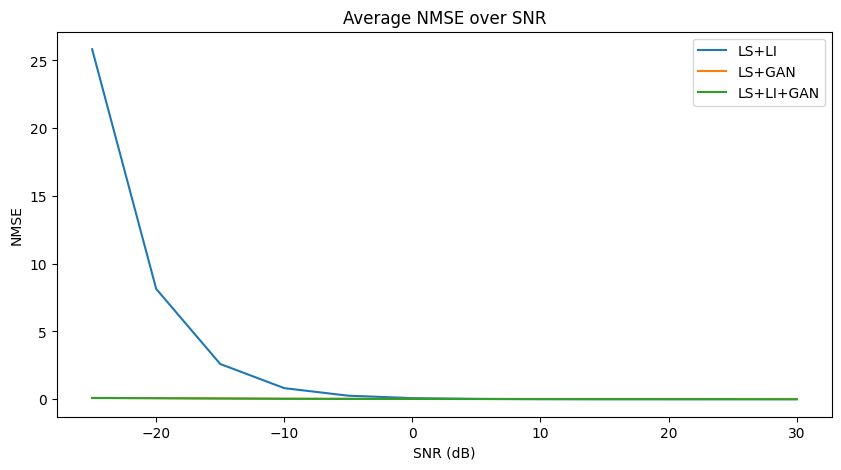

Figure saved at 
../transferd_model/static/GAN/ver9_/NMSE1.png


In [5]:
plt.figure(figsize=(10, 5))
plt.plot(SNR, nmse_LS_LI_val, label='LS+LI')
plt.plot(SNR, nmse_LS_NN_val, label='LS+GAN')
plt.plot(SNR, nmse_LI_NN_val, label='LS+LI+GAN')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE')
plt.title('Average NMSE over SNR')
plt.legend()
plt.savefig(os.path.join(transferd_save_path, "NMSE1.png")) # transferd_save_path = f"transferd_model/static/GAN/ver{idx_save_path}_"
plt.show()
print('Figure saved at ')
print(os.path.join(transferd_save_path, "NMSE1.png"))

savemat(os.path.join(transferd_save_path, 'NMSE.mat'), {'nmse_LS_LI_val': nmse_LS_LI_val, 'nmse_LS_NN_val':nmse_LS_NN_val, 'nmse_LI_NN_val':nmse_LI_NN_val})


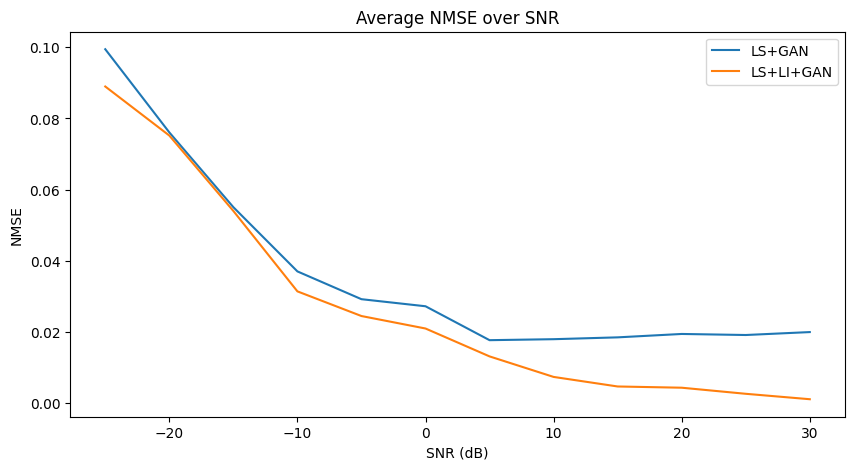

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(SNR, nmse_LS_NN_val, label='LS+GAN')
plt.plot(SNR, nmse_LI_NN_val, label='LS+LI+GAN')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE')
plt.title('Average NMSE over SNR')
plt.legend()
plt.show()

In [7]:
nmse_LI_NN_val

[tensor(0.0890),
 tensor(0.0752),
 tensor(0.0540),
 tensor(0.0314),
 tensor(0.0245),
 tensor(0.0210),
 tensor(0.0131),
 tensor(0.0074),
 tensor(0.0047),
 tensor(0.0043),
 tensor(0.0026),
 tensor(0.0011)]